In [10]:
%pip install kneed

Note: you may need to restart the kernel to use updated packages.


In [11]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load
import warnings
warnings.filterwarnings("ignore")
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
pd.options.mode.chained_assignment = None
import json
from pprint import pprint
from sklearn.model_selection import train_test_split
from sklearn.ensemble import IsolationForest
from sklearn.cluster import DBSCAN
import scipy
from sklearn.neighbors import NearestNeighbors,LocalOutlierFactor
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler,LabelEncoder,StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.cluster import OPTICS,KMeans
from numpy import quantile, where, random
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant
from kneed import DataGenerator, KneeLocator

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/weather-data-1940-2023-daily/data_2023-05-26.json


# Intro and Data Prep

We're going to analyze some interesting and unusual weather patterns in 7 cities across the globe. These cities include Tokyo, Sydney, Cape Town, Rio de Janeiro, Moscow, Toronto, and Reykjavik. To gather the necessary data, we used the convenient https://open-meteo.com/ API, which provides weather information. Our dataset contains daily data spanning from 1940 to 2023. For our analysis, we will focus on the period from 1940 to 1970 as our training data, wherever applicable.

We will be using 3 unsupervised learning models to find weather anomalies: OPTICS, Local Outlier Factor and Isolation Forest.

If you're interested in accessing the code for extracting data from the API or in Tableau dashboard presentation based on this data, please visit: https://github.com/IPopovSci/Weather_Anomaly_Detection

In [12]:
with open('/kaggle/input/weather-data-1940-2023-daily/data_2023-05-26.json', "r") as file:
    data_json = json.load(file) 

#Load every city as a list of dicts
data_parsed = []
for city in data_json:
    data_parsed.append(json.loads(city))

Given the extensive size of our dataset, it would be beneficial to utilize a tool that can help us understand the structure of the JSON data before we move forward.

In [13]:
def display_json_keys(data, indent=0):
    if isinstance(data, dict):
        print(f"{' ' * indent}Dictionary:")
        indent+=2
        for key in data.keys():
            print(f"{' ' * indent}{key}:")
            display_json_keys(data[key], indent + 2)
    elif isinstance(data, list):
        print(f"{' ' * indent}List:")
        indent+=2
        for item in data:
            display_json_keys(item, indent)
            break
display_json_keys(data_parsed)

List:
  Dictionary:
    latitude:
    longitude:
    generationtime_ms:
    utc_offset_seconds:
    timezone:
    timezone_abbreviation:
    elevation:
    daily_units:
      Dictionary:
        time:
        weathercode:
        temperature_2m_max:
        temperature_2m_min:
        temperature_2m_mean:
        apparent_temperature_max:
        apparent_temperature_min:
        apparent_temperature_mean:
        precipitation_sum:
        rain_sum:
        snowfall_sum:
        windspeed_10m_max:
        windgusts_10m_max:
    daily:
      Dictionary:
        time:
          List:
        weathercode:
          List:
        temperature_2m_max:
          List:
        temperature_2m_min:
          List:
        temperature_2m_mean:
          List:
        apparent_temperature_max:
          List:
        apparent_temperature_min:
          List:
        apparent_temperature_mean:
          List:
        precipitation_sum:
          List:
        rain_sum:
          List:
        snow

Due to the intricate nature of our JSON structure, it will be necessary to normalize the JSON for each list present in order to create a dataframe. This process allows us to organize the data in a structured and tabular format.

In [14]:
keys_to_normalize = list(data_parsed[0]['daily'].keys()) #This is ok, because each entry has the same structure
weather_df = pd.DataFrame()
n=0
for nkey in keys_to_normalize:
    if n!=1: #Hacky way to add location name without duplicating
        concat_df = pd.json_normalize(data_parsed,record_path=['daily',[f'{nkey}']],meta='location_name')
        n=1
    else:
        concat_df = pd.json_normalize(data_parsed, record_path=['daily', [f'{nkey}']])
        concat_df.rename(columns={concat_df.columns[0]: f"{nkey}"}, inplace=True)
    weather_df=pd.concat([weather_df,concat_df],axis=1)

To ensure easier readability and maintain the integrity of the original data, we will create a deep copy of the dataset. This will allow us to work with a separate copy of the data while preserving the original dataset in its entirety.

In [15]:
weather_df.rename(columns={0:'time'},inplace=True)
weather_df['time']=pd.to_datetime(weather_df.loc[:,'time'],format='%Y-%m-%d')
weather_df=weather_df.loc[ (weather_df['time'].dt.year != 2023) | (weather_df['time'].dt.year != 1940)]
weather_df.info()
weather_df.describe()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 213192 entries, 0 to 213191
Data columns (total 14 columns):
 #   Column                     Non-Null Count   Dtype         
---  ------                     --------------   -----         
 0   time                       213192 non-null  datetime64[ns]
 1   location_name              213192 non-null  object        
 2   weathercode                213185 non-null  float64       
 3   temperature_2m_max         213185 non-null  float64       
 4   temperature_2m_min         213185 non-null  float64       
 5   temperature_2m_mean        213185 non-null  float64       
 6   apparent_temperature_max   213185 non-null  float64       
 7   apparent_temperature_min   213185 non-null  float64       
 8   apparent_temperature_mean  213185 non-null  float64       
 9   precipitation_sum          213178 non-null  float64       
 10  rain_sum                   213178 non-null  float64       
 11  snowfall_sum               213178 non-null  float64 

,weathercode,temperature_2m_max,temperature_2m_min,temperature_2m_mean,apparent_temperature_max,apparent_temperature_min,apparent_temperature_mean,precipitation_sum,rain_sum,snowfall_sum,windspeed_10m_max,windgusts_10m_max
count,213185.000000,213185.000000,213185.000000,213185.000000,213185.000000,213185.000000,213185.000000,213178.000000,213178.000000,213178.000000,213185.000000,213178.000000
mean,32.230828,16.260062,9.198035,12.556049,15.034069,7.388662,10.956299,2.492756,2.282464,0.153599,19.764454,37.914080
std,28.509401,10.507155,9.902200,9.944868,13.271896,12.468145,12.564843,6.118349,6.009613,0.820272,7.737461,13.943479
min,0.000000,-37.800000,-42.500000,-39.800000,-42.800000,-48.100000,-45.100000,0.000000,0.000000,0.000000,3.400000,7.200000
25%,2.000000,9.100000,2.700000,5.800000,5.400000,-1.500000,1.900000,0.000000,0.000000,0.000000,14.200000,28.100000
50%,51.000000,18.100000,10.800000,14.300000,16.600000,8.700000,12.500000,0.100000,0.000000,0.000000,18.300000,35.600000
75%,55.000000,24.300000,16.900000,20.300000,25.300000,16.800000,20.700000,2.300000,1.800000,0.000000,23.800000,45.400000
max,75.000000,44.900000,28.500000,34.200000,45.700000,34.200000,37.900000,232.900000,232.900000,33.740000,84.100000,156.600000


# EDA and Data Treatment

We've got a handy helper class here that will assist us in examining and handling our data.

In [16]:
location_names=['Tokyo','Sydney','Cape Town','Rio de Janeiro','Moscow','Toronto','Reykjavik']
class DataWorker():
    def __init__(self,data,location_name):
        self.skewed_columns = []
        self.float_columns = []
        self.data = data[data['location_name']==location_name]
        self.data_orig= self.data.copy(deep=True)
        self.X_train=None
        self.X_test=None
        self.X_total=None
        self.X_train_orig=None
        self.X_test_orig=None

    def na_check(self,drop_na=True):
        print('Are missing values present? ',[True if str(pd.isnull(self.data).any) else False])
        if pd.isnull(self.data).values.any:
            print('There are ', pd.isnull(self.data).sum().sum(), ' missing values present')
            if drop_na:
                self.data=self.data.dropna()
                self.data_orig=self.data_orig.dropna()
        return self

    def datetime_index_na_check(self): #If index is datetime, check for missing values
        if self.data.index.inferred_type == "datetime64":
            missing_elements = pd.date_range(self.data.index.min(), self.data.index.max()).difference(self.data.index)
            print('Missing dates in the index are, ', [missing_elements if len(missing_elements)!=0 else 'All dates are present'])
        else:
            print('Not a datetime index')
        return self

    def check_duplicates(self):
        print('Are there any duplicates? ',self.data.duplicated().any())
        print('Index duplicates? ',self.data.index.duplicated().any())
        return self
        
    def check_uniform(self,log_transform=True):
        for column in self.data.columns:
            if self.data[column].dtype == 'float64':
                column_skew = self.data[column].skew()
                print(f'For column {column} the skew is {column_skew}')
                if column_skew>1:
                    self.skewed_columns.append(column)
        print('-' * 25)
        if log_transform:
            for column in self.skewed_columns:
                self.data[column] = np.sign(self.data[column])*np.log1p(self.data[column])
                column_skew = self.data[column].skew()
                print(f'For column {column} the skew after negative log normalization is {column_skew}')
        return self
    def get_float_cols(self):
        for column in self.data.columns:
            if self.data[column].dtype == 'float64' and (column not in self.float_columns):
                self.float_columns.append(column)
        return self
    def add_time_feats(self):
        self.data.loc[:,'month_sin'] = np.sin((2*np.pi*(pd.to_datetime(self.data.loc[:,'time'])).dt.month)/12)
        self.data.loc[:,'month_cos'] = np.cos((2*np.pi*(pd.to_datetime(self.data.loc[:,'time'])).dt.month)/12)
        self.float_columns.extend(['month_sin','month_cos'])
        return self
    def train_test(self):
        self.X_train, self.X_test = train_test_split(self.data, test_size=0.6, random_state=42,shuffle=False)
        self.X_train_orig, self.X_test_orig = train_test_split(self.data_orig, test_size=0.6, random_state=42,shuffle=False)
        return self

    def normalize(self,std=True,mm=False):
        trans_list=[]
        if std:
            trans_list.append(('std', StandardScaler() , self.float_columns))
        if mm:
            trans_list.append(('mm', MinMaxScaler(), self.float_columns))
        if (not mm) and (not std):
            trans_list.append(('dummy','passthrough', self.float_columns))
        preprocessor = ColumnTransformer(
        remainder='drop', #passthough features not listed
        transformers=trans_list)
        print('Features used: ', data_worker.X_train.columns)
        self.X_train=preprocessor.fit_transform(self.X_train)
        self.X_test= preprocessor.transform(self.X_test)
        self.X_train=self.X_train[:,-(len(self.data)):]
        self.X_test=self.X_test[:,-(len(self.data)):]
        self.X_total=np.concatenate((self.X_train,self.X_test),axis=0)
        self.X_total_orig=np.concatenate((self.X_train_orig,self.X_test_orig),axis=0)
        return self
    # compute the vif for all given features
    def compute_vif(self):

        X = self.data[self.float_columns]
        # the calculation of variance inflation requires a constant
        X['intercept'] = 1

        # create dataframe to store vif values
        vif = pd.DataFrame()
        vif["Variable"] = X.columns
        vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
        vif = vif[vif['Variable']!='intercept']
        print(vif)
        return self

The majority of these functions focus on performing basic data-integrity checks, such as identifying missing values, detecting duplicates, extracting numerical features, and creating train-test splits.

However, two functions stand out as particularly important: compute_vif and normalize. The compute_vif function enables us to assess the presence of collinearity among our features. As the OPTICS and Local Outlier Factor models struggle with collinear features, we will need to eliminate features until we achieve a satisfactory level of collinearity. On the other hand, the Isolation Forest model doesn't encounter this issue and can freely utilize all the available features.

Normalization is also crucial for the OPTICS and Local Outlier Factor models. By normalizing the distances between features, we facilitate the identification of anomaly clusters by these clustering algorithms.

Additionally, we attempted to engineer monthly cyclical time features. However, these features exhibited significant correlation with mean temperatures, rendering them less meaningful and useful for our analysis. Moreover, incorporating daily cyclical time features wouldn't make much sense either, as we don't need to associate the 20th day of a winter month with the 20th day of a summer month any more closely than necessary.

In [17]:
data_worker = DataWorker(weather_df,'Moscow')
data_worker.na_check().datetime_index_na_check().check_duplicates().check_uniform().get_float_cols().compute_vif()
data_worker.data.drop(['rain_sum','snowfall_sum','temperature_2m_mean','apparent_temperature_mean','apparent_temperature_max','apparent_temperature_min','temperature_2m_min','windspeed_10m_max'],axis=1,inplace=True)
data_worker.float_columns=[col for col in data_worker.float_columns if col not in ['rain_sum','snowfall_sum','temperature_2m_mean','apparent_temperature_mean','apparent_temperature_max','apparent_temperature_min','temperature_2m_min','windspeed_10m_max']]
data_worker.train_test().normalize()

Are missing values present?  [True]
There are  16  missing values present
Not a datetime index
Are there any duplicates?  False
Index duplicates?  False
For column weathercode the skew is -0.23380358697089867
For column temperature_2m_max the skew is -0.21554830316131546
For column temperature_2m_min the skew is -0.5179276105328456
For column temperature_2m_mean the skew is -0.35248125356706733
For column apparent_temperature_max the skew is -0.08268353567225475
For column apparent_temperature_min the skew is -0.3191085048088561
For column apparent_temperature_mean the skew is -0.18538606092830273
For column precipitation_sum the skew is 3.953888074408987
For column rain_sum the skew is 4.731758110168413
For column snowfall_sum the skew is 5.038655660456995
For column windspeed_10m_max the skew is 0.5153800316446605
For column windgusts_10m_max the skew is 0.5102974821021472
-------------------------
For column precipitation_sum the skew after negative log normalization is 1.1996001781

We noticed that the missing values are located at the beginning and end of the dataset, and we can safely remove them without impacting our analysis. Additionally, we encountered some skewed variables that we attempted to correct using a negative-log transform.

Speaking of collinear features, we found significant correlations among all the temperature variables, as well as among the precipitation and wind variables. After careful consideration, we decided to retain only the 'temperature_2m_max', 'precipitation_sum', 'windgusts_10m_max','weathercode', and 'city_name' (encoded) variables for both the OPTICS and LOF models. However, for the Isolation Forest model, we included all the available variables without any exclusions.

city_name variable was label-encoded to reduce training time, but in retrospective one-hot encoding would likely provide a better result from OPTICS and LOF models.

# OPTICS Algorithm

The OPTICS algorithm, which is based on DBScan, is expected to perform well for our analysis. Unlike other models, OPTICS does not require training and is capable of identifying outliers across the entire range of our dataset (1940-2023).

To identify potential outliers using OPTICS, we will focus on the top 2.5% of core distance scores. The only hyper-parameter we need to tune is the min_samples parameter, which we will set to 2 times the dimension of the data, following the recommendation in the paper by Sander et al. (1998). In our analysis, we observed that utilizing the 'brute' algorithm yielded higher R values when examining the relationship between the count of anomalies and the corresponding years for most cities. Given our understanding of climate change, it is reasonable to expect a positive linear trend in this correlation. Although one could argue that incorporating this prior knowledge may influence the model, it is important to note that the parameter function primarily determines the optimization methods for anomaly detection. Additionally, due to the absence of validation data, we considered this interpretation of model performance to be acceptable and valid within the scope of our analysis.

Are missing values present?  [True]
There are  16  missing values present
Not a datetime index
Are there any duplicates?  False
Index duplicates?  False
For column weathercode the skew is -0.1265399448592719
For column temperature_2m_max the skew is -0.06178609123037139
For column temperature_2m_min the skew is -0.08725141152044845
For column temperature_2m_mean the skew is -0.08095571840544646
For column apparent_temperature_max the skew is 0.05748580021773185
For column apparent_temperature_min the skew is 0.0646916866430364
For column apparent_temperature_mean the skew is 0.04878594469898302
For column precipitation_sum the skew is 5.585894462508631
For column rain_sum the skew is 5.6670127910069334
For column snowfall_sum the skew is 26.886275263755895
For column windspeed_10m_max the skew is 1.4004094949733379
For column windgusts_10m_max the skew is 1.5334073330122118
-------------------------
For column precipitation_sum the skew after negative log normalization is 1.30205572995

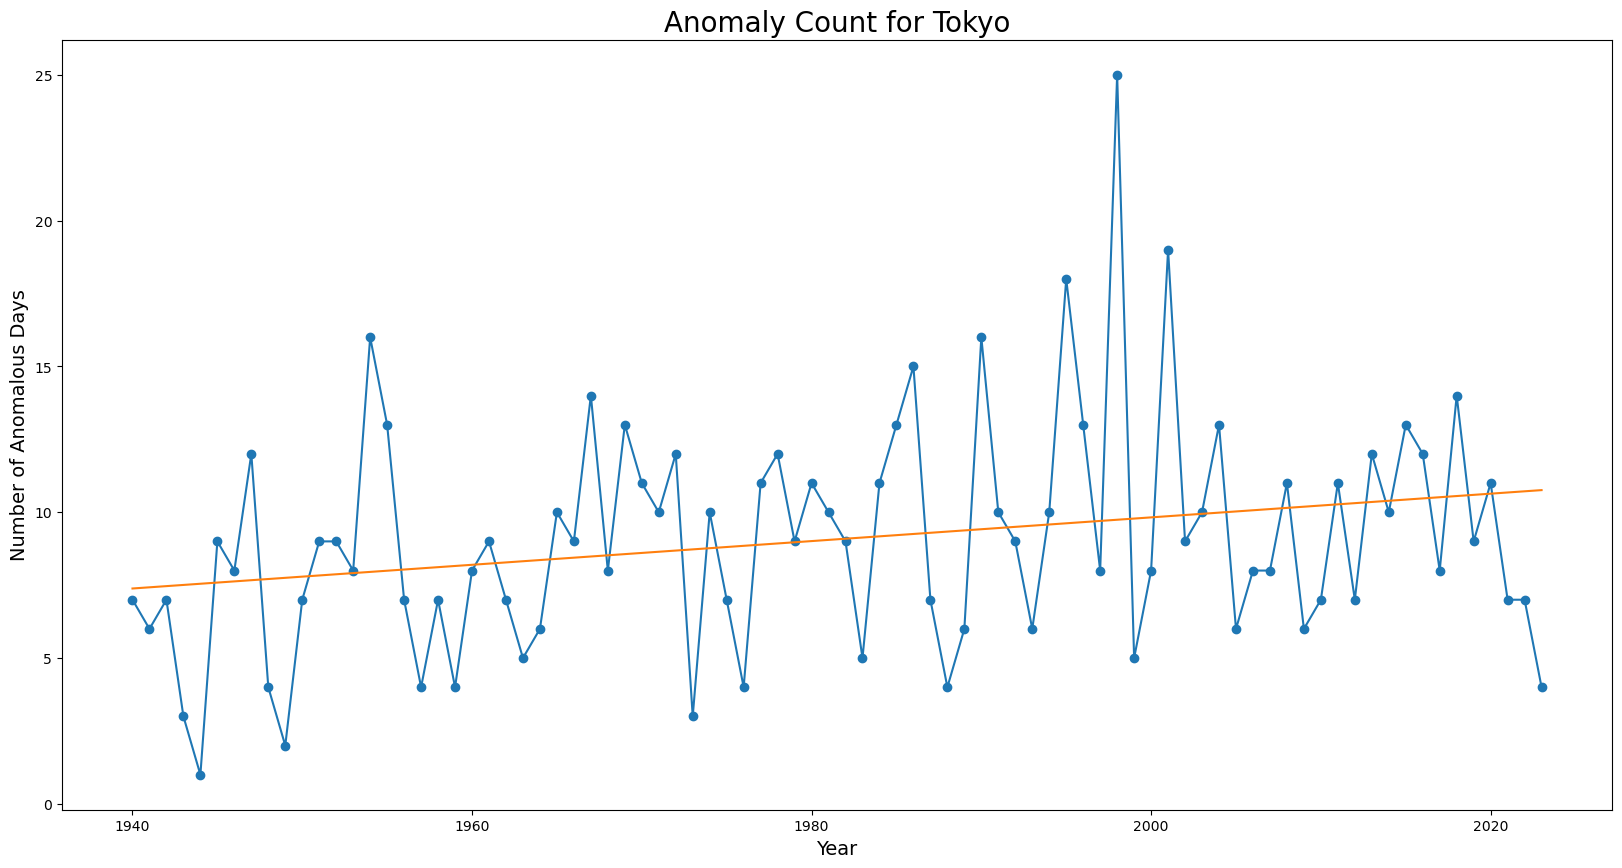

0.04063987040599371 -71.45647463804796 0.25129892386453306 0.021120847893471677 0.017285801582453665
Are missing values present?  [True]
There are  16  missing values present
Not a datetime index
Are there any duplicates?  False
Index duplicates?  False
For column weathercode the skew is 0.017848025660578148
For column temperature_2m_max the skew is 0.49117018852138605
For column temperature_2m_min the skew is -0.18155622566585713
For column temperature_2m_mean the skew is 0.03291517939899382
For column apparent_temperature_max the skew is 0.2925286608313183
For column apparent_temperature_min the skew is -0.027364779500601528
For column apparent_temperature_mean the skew is 0.05812973532744846
For column precipitation_sum the skew is 8.472133277021962
For column rain_sum the skew is 8.472133277021962
For column snowfall_sum the skew is 0
For column windspeed_10m_max the skew is 0.613665613498732
For column windgusts_10m_max the skew is 0.5126431639300124
-------------------------
For 

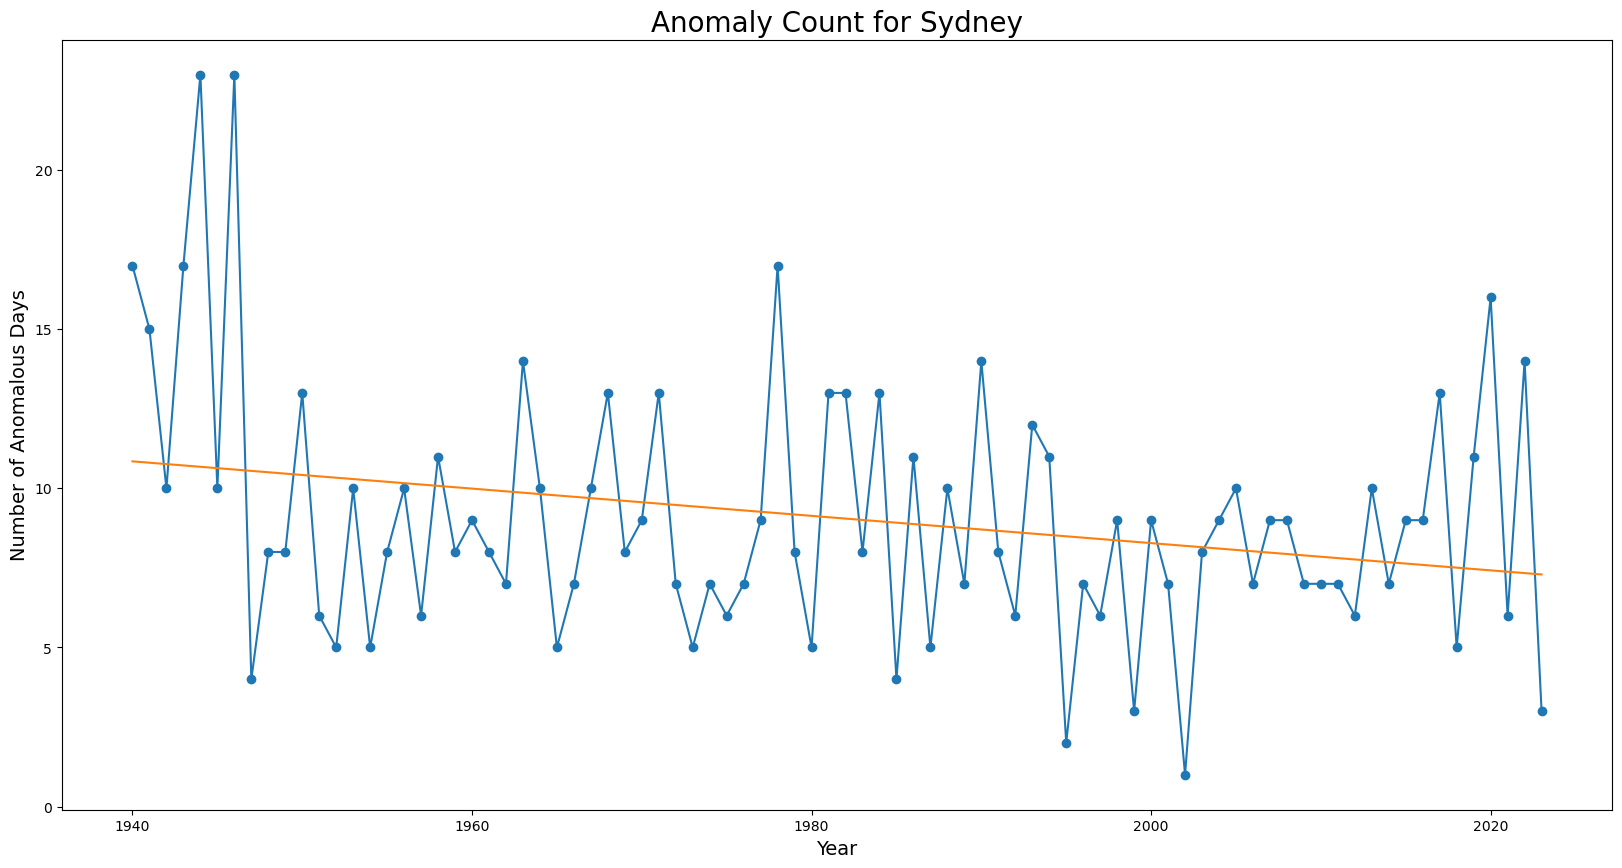

-0.04282676926192163 93.93267186392629 -0.2579245181614221 0.01784952692269375 0.017716057937539016
Are missing values present?  [True]
There are  16  missing values present
Not a datetime index
Are there any duplicates?  False
Index duplicates?  False
For column weathercode the skew is 0.8336834035336033
For column temperature_2m_max the skew is 0.3324723198671698
For column temperature_2m_min the skew is -0.199788979433292
For column temperature_2m_mean the skew is 0.21784739156424263
For column apparent_temperature_max the skew is 0.23345258384496873
For column apparent_temperature_min the skew is -0.006720257796416035
For column apparent_temperature_mean the skew is 0.22709405728713308
For column precipitation_sum the skew is 5.1097097933417235
For column rain_sum the skew is 5.1097097933417235
For column snowfall_sum the skew is 0
For column windspeed_10m_max the skew is 0.3927016540912775
For column windgusts_10m_max the skew is 0.33672666309819993
-------------------------
For c

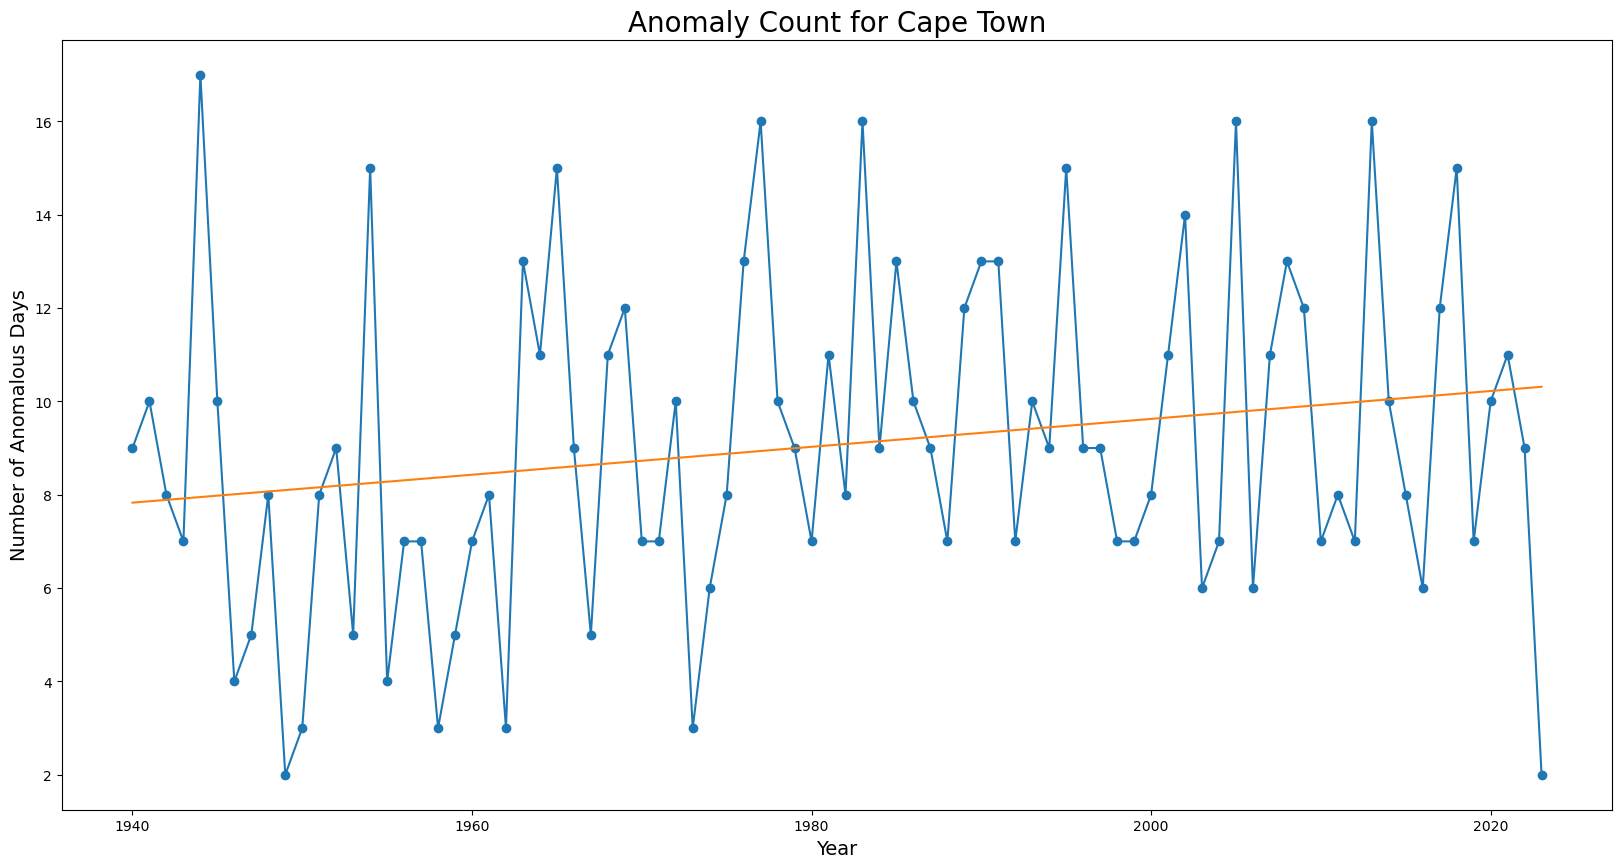

0.029907866761162295 -50.19100941581452 0.20476275960529008 0.061704778920161275 0.01578798332960837
Are missing values present?  [True]
There are  16  missing values present
Not a datetime index
Are there any duplicates?  False
Index duplicates?  False
For column weathercode the skew is -0.30157163944965315
For column temperature_2m_max the skew is 0.10189557331300489
For column temperature_2m_min the skew is -0.2951974227555679
For column temperature_2m_mean the skew is 0.10196192958507239
For column apparent_temperature_max the skew is 0.04032449032400999
For column apparent_temperature_min the skew is -0.17447174110510721
For column apparent_temperature_mean the skew is 0.028176338592956335
For column precipitation_sum the skew is 6.489547471245604
For column rain_sum the skew is 6.489547471245604
For column snowfall_sum the skew is 0
For column windspeed_10m_max the skew is 0.914656117926115
For column windgusts_10m_max the skew is 1.0213601055380666
-------------------------
For 

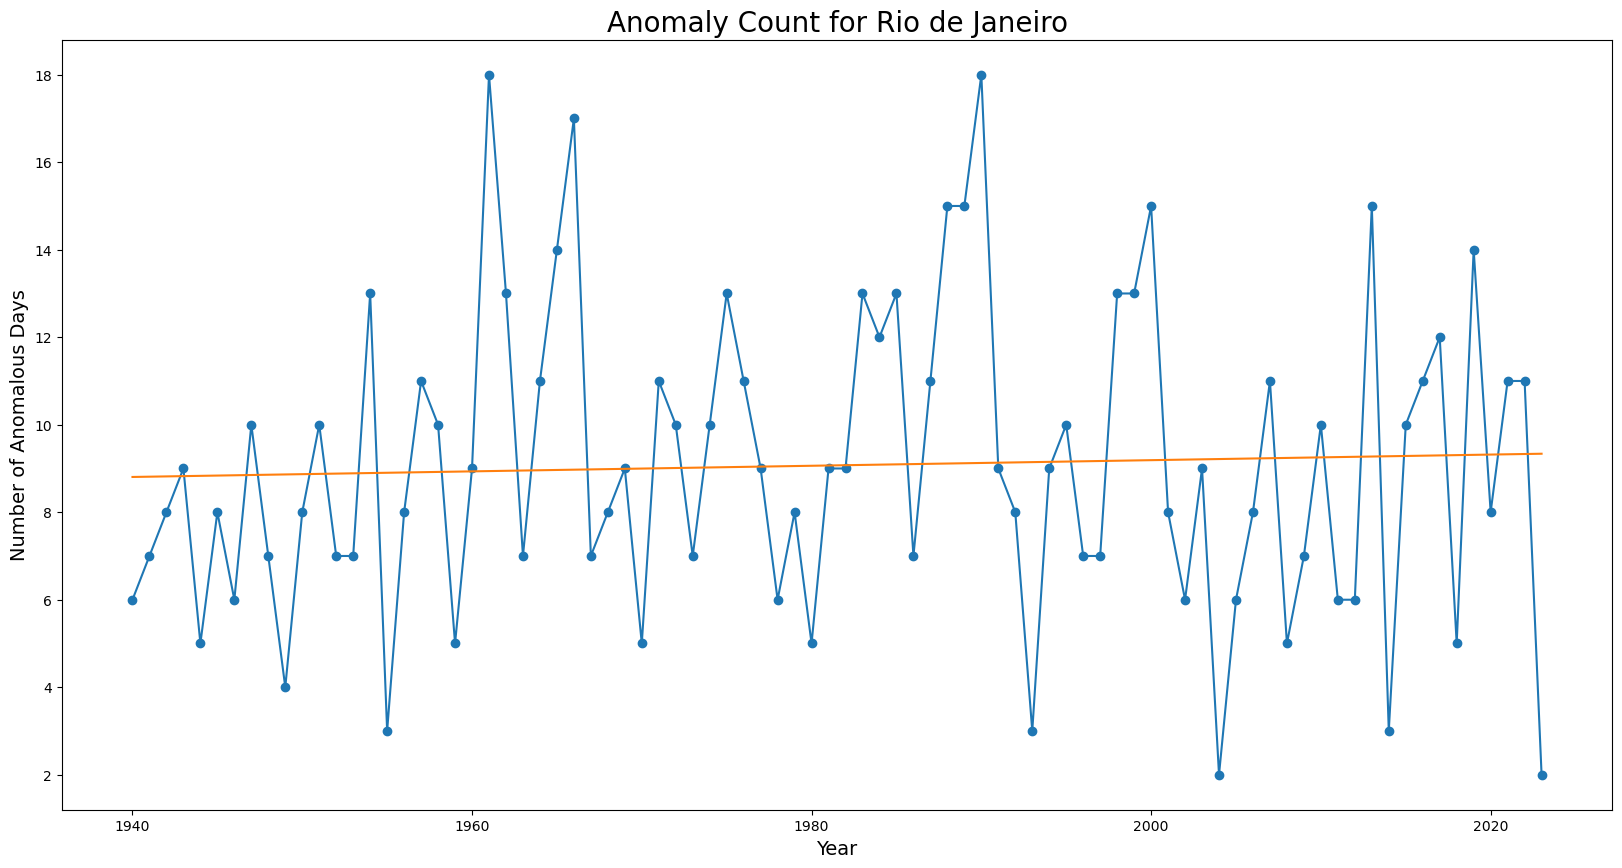

0.006398704059937227 -3.607603523337044 0.044144901436198355 0.6900945262392271 0.0159911966289745
Are missing values present?  [True]
There are  16  missing values present
Not a datetime index
Are there any duplicates?  False
Index duplicates?  False
For column weathercode the skew is -0.23380358697089867
For column temperature_2m_max the skew is -0.21554830316131546
For column temperature_2m_min the skew is -0.5179276105328456
For column temperature_2m_mean the skew is -0.35248125356706733
For column apparent_temperature_max the skew is -0.08268353567225475
For column apparent_temperature_min the skew is -0.3191085048088561
For column apparent_temperature_mean the skew is -0.18538606092830273
For column precipitation_sum the skew is 3.953888074408987
For column rain_sum the skew is 4.731758110168413
For column snowfall_sum the skew is 5.038655660456995
For column windspeed_10m_max the skew is 0.5153800316446605
For column windgusts_10m_max the skew is 0.5102974821021472
-------------

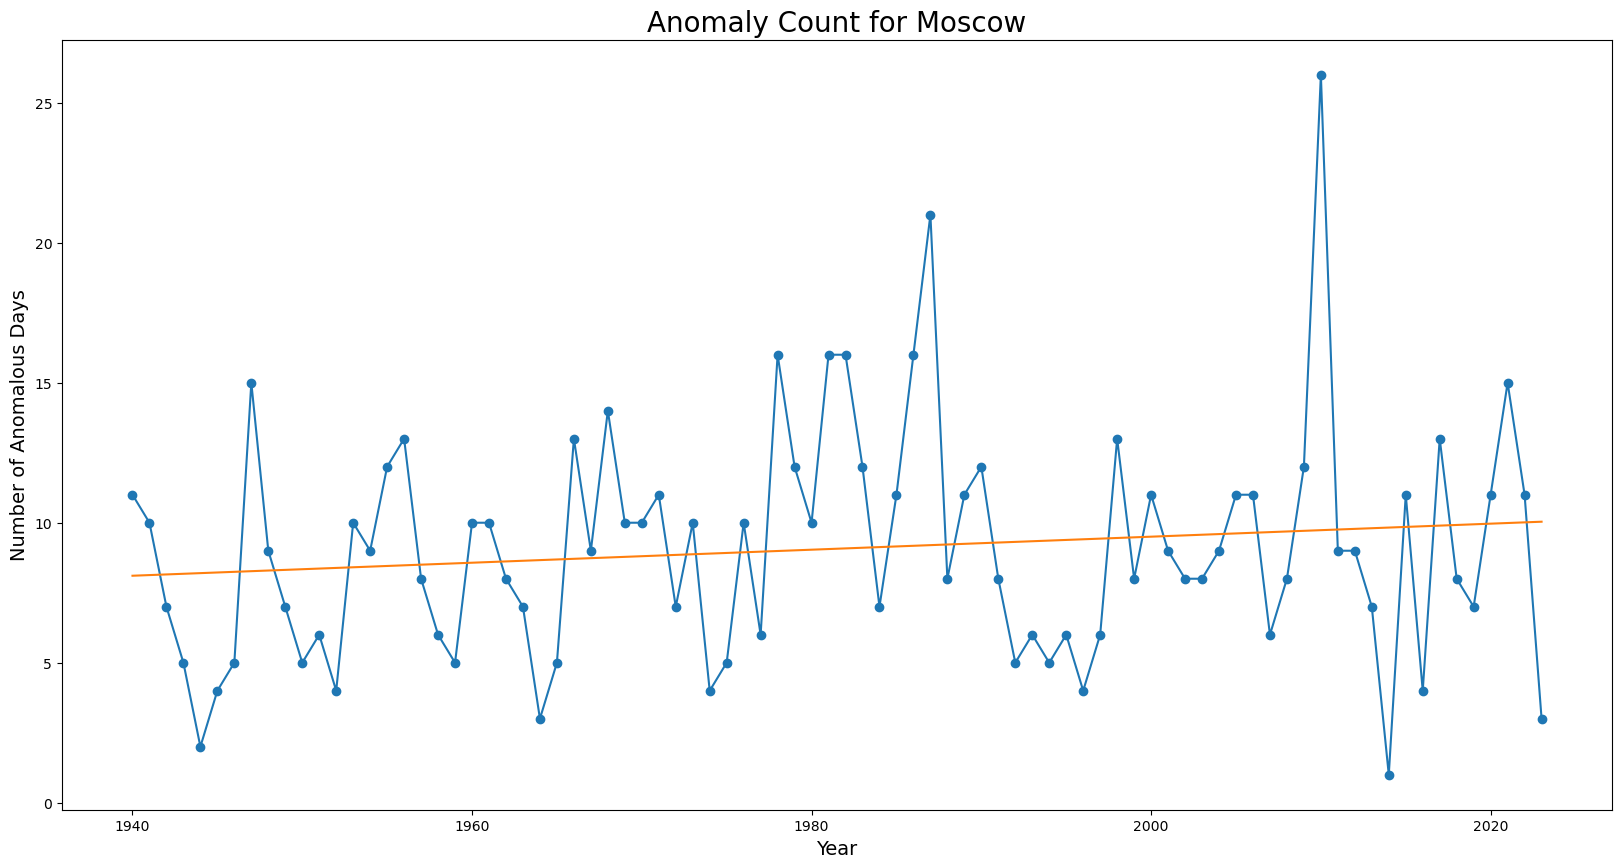

0.02324592487597448 -36.99037157031486 0.1370124448344995 0.21394356955435226 0.01855943553215271
Are missing values present?  [True]
There are  16  missing values present
Not a datetime index
Are there any duplicates?  False
Index duplicates?  False
For column weathercode the skew is 0.0337306606468472
For column temperature_2m_max the skew is -0.15139228693910517
For column temperature_2m_min the skew is -0.3114665407326778
For column temperature_2m_mean the skew is -0.23487428582220699
For column apparent_temperature_max the skew is -0.04279264369486245
For column apparent_temperature_min the skew is -0.1279375469632176
For column apparent_temperature_mean the skew is -0.08482708628630689
For column precipitation_sum the skew is 3.758533753188742
For column rain_sum the skew is 4.201401279519052
For column snowfall_sum the skew is 8.060570599937181
For column windspeed_10m_max the skew is 0.6479145046883349
For column windgusts_10m_max the skew is 0.7947652018388165
----------------

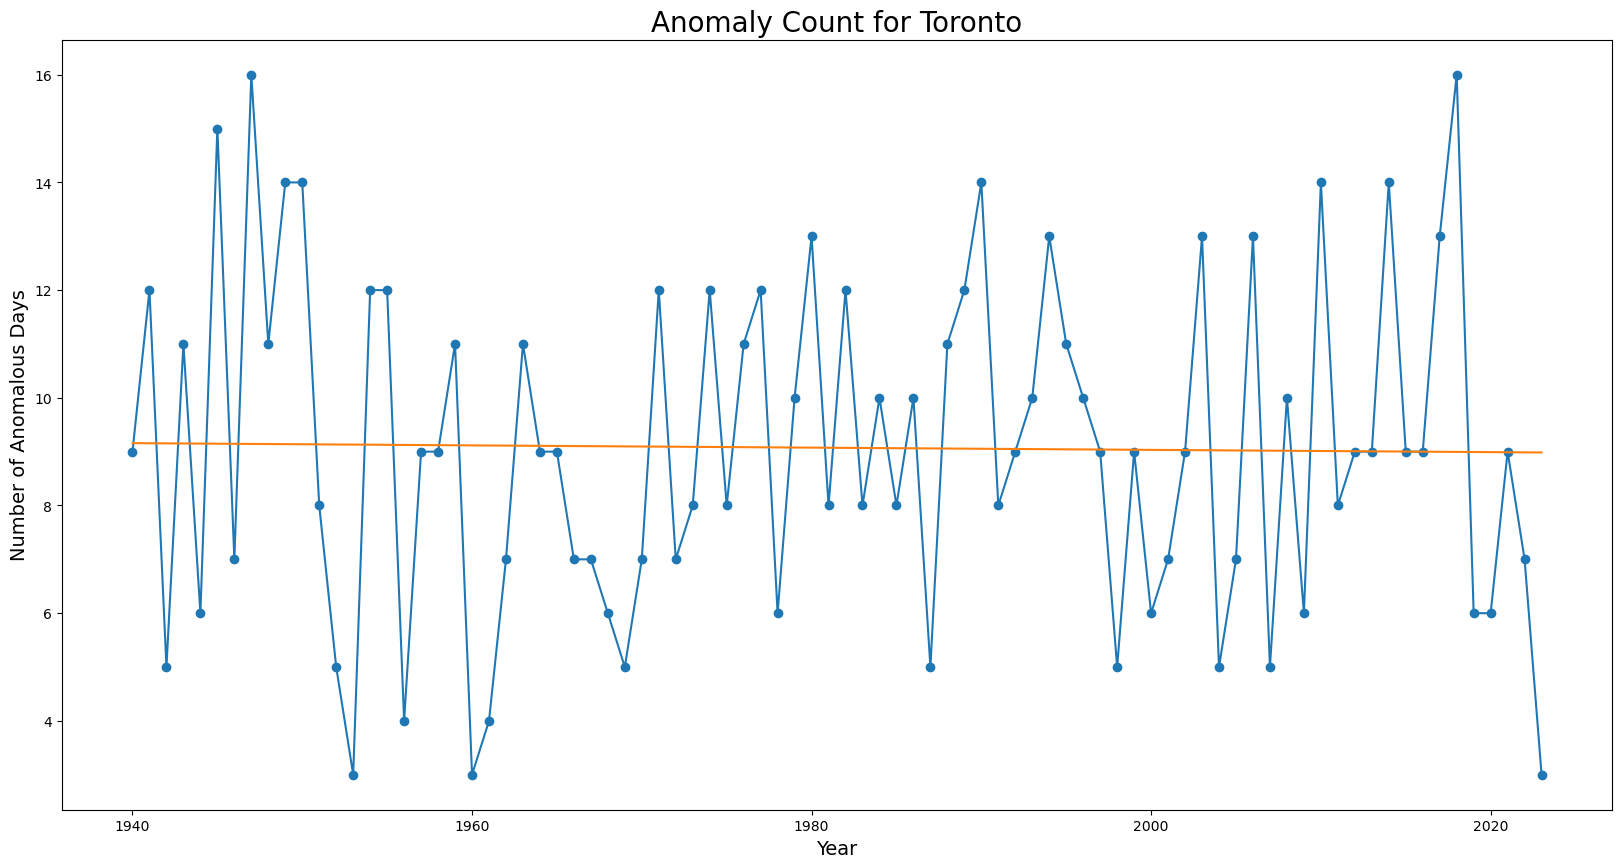

-0.0020856535385238425 13.204151058013565 -0.01617026107682219 0.8839278933631611 0.014241686518244282
Are missing values present?  [True]
There are  16  missing values present
Not a datetime index
Are there any duplicates?  False
Index duplicates?  False
For column weathercode the skew is -0.6476998547361354
For column temperature_2m_max the skew is -0.4506466617535143
For column temperature_2m_min the skew is -0.7089932577989368
For column temperature_2m_mean the skew is -0.6063582356753093
For column apparent_temperature_max the skew is -0.2669641886487235
For column apparent_temperature_min the skew is -0.4441569370967343
For column apparent_temperature_mean the skew is -0.36714890150206625
For column precipitation_sum the skew is 2.215177210574176
For column rain_sum the skew is 2.4368126555554803
For column snowfall_sum the skew is 5.173882900620852
For column windspeed_10m_max the skew is 0.6636944112416375
For column windgusts_10m_max the skew is 0.8085904906301513
------------

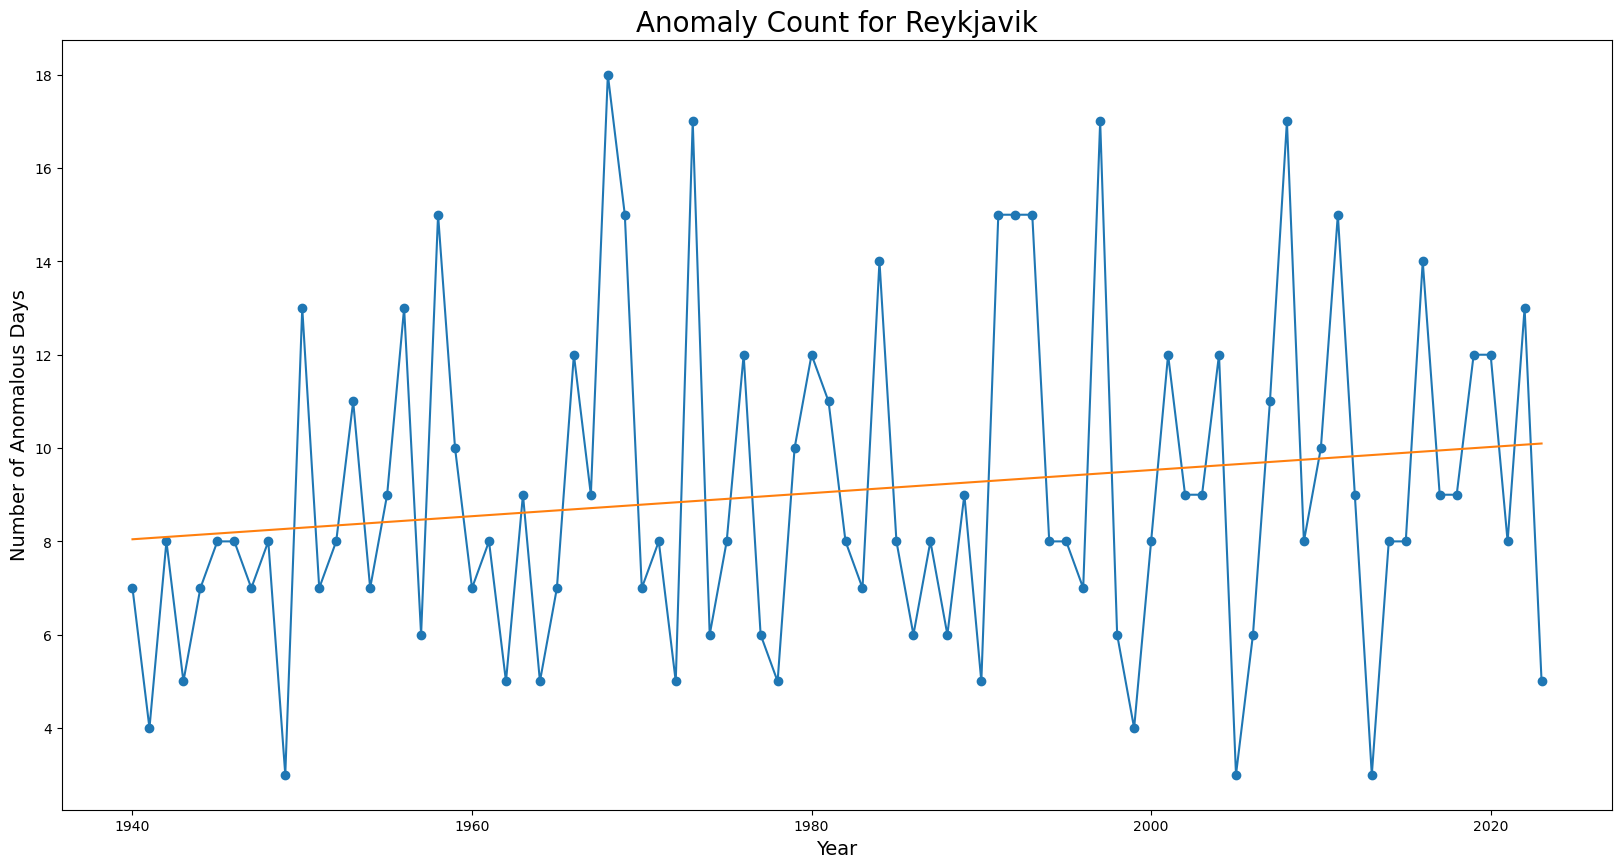

0.02472410651007391 -39.91938847828288 0.1691119594539951 0.12409466036308679 0.015912509047361988


In [18]:
for city in location_names:
    data_worker = DataWorker(weather_df,city)
    data_worker.na_check().datetime_index_na_check().check_duplicates().check_uniform().get_float_cols()
    data_worker.data.drop(['rain_sum','snowfall_sum','temperature_2m_mean','apparent_temperature_mean','apparent_temperature_max','apparent_temperature_min','temperature_2m_min','windspeed_10m_max'],axis=1,inplace=True)
    data_worker.float_columns=[col for col in data_worker.float_columns if col not in ['rain_sum','snowfall_sum','temperature_2m_mean','apparent_temperature_mean','apparent_temperature_max','apparent_temperature_min','temperature_2m_min','windspeed_10m_max']]
    data_worker.train_test()
    data_worker.normalize()
    data_worker.compute_vif()
    clustering = OPTICS(min_samples=2*data_worker.X_total.shape[1],n_jobs=-1,algorithm='brute').fit(data_worker.X_total)
    scores = clustering.core_distances_ 
    thresh = quantile(scores, .975)
    index = where(scores >= thresh)
    data_worker.X_total_orig=pd.DataFrame(data_worker.X_total_orig)
    data_worker.X_total_orig.iloc[:,0]=pd.to_datetime(data_worker.X_total_orig.iloc[:,0],format='%Y-%m-%d')
    outliers = data_worker.X_total_orig.iloc[index]
    outliers=pd.DataFrame(outliers)
    outliers.to_csv(f'OPTICS_outliers_{city}.csv')
    outliers = data_worker.X_total_orig.iloc[index].groupby(data_worker.X_total_orig.iloc[:,0].dt.year).count()
    plt.figure(figsize=(20,10))
    plt.plot(outliers.iloc[:,-1])
    a, b = np.polyfit(np.array(np.linspace(min(data_worker.X_total_orig.iloc[:,0].dt.year),max(data_worker.X_total_orig.iloc[:,0].dt.year),num=len(outliers))), outliers.iloc[:,-1], 1)
    x=np.array(np.linspace(min(data_worker.X_total_orig.iloc[:,0].dt.year),max(data_worker.X_total_orig.iloc[:,0].dt.year),num=len(outliers)))
    y=outliers.iloc[:,-1]
    plt.scatter(x, y)

    #add line of best fit to plot
    plt.plot(x, a*x+b)   
    plt.title(f'Anomaly Count for {city}',fontsize=20)
    plt.xlabel('Year',fontsize=14)
    plt.ylabel('Number of Anomalous Days',fontsize=14)
    plt.show()
    slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(x, y)
    print(slope,intercept,r_value,p_value,std_err)

# Local Outlier Factor

The Local Outlier Factor (LOF) algorithm is capable of both identifying novelties (outliers in new data) and detecting outliers in the overall dataset. In our analysis, we will utilize the novelty method, which enables us to establish a baseline using the 1940-1970 period and detect anomalies in future data.

The primary hyperparameter for LOF is the number of neighbors (n_neighbors) since it is a neighbors-based algorithm. To determine an appropriate value for this hyperparameter, we will employ the 'elbow' method. To simplify the process and avoid the need to identify the elbow point for each city individually, we will utilize the kneedle library, which automatically identifies the optimal n_neighbors value.

Are missing values present?  [True]
There are  16  missing values present
Not a datetime index
Are there any duplicates?  False
Index duplicates?  False
For column weathercode the skew is -0.1265399448592719
For column temperature_2m_max the skew is -0.06178609123037139
For column temperature_2m_min the skew is -0.08725141152044845
For column temperature_2m_mean the skew is -0.08095571840544646
For column apparent_temperature_max the skew is 0.05748580021773185
For column apparent_temperature_min the skew is 0.0646916866430364
For column apparent_temperature_mean the skew is 0.04878594469898302
For column precipitation_sum the skew is 5.585894462508631
For column rain_sum the skew is 5.6670127910069334
For column snowfall_sum the skew is 26.886275263755895
For column windspeed_10m_max the skew is 1.4004094949733379
For column windgusts_10m_max the skew is 1.5334073330122118
-------------------------
For column precipitation_sum the skew after negative log normalization is 1.30205572995

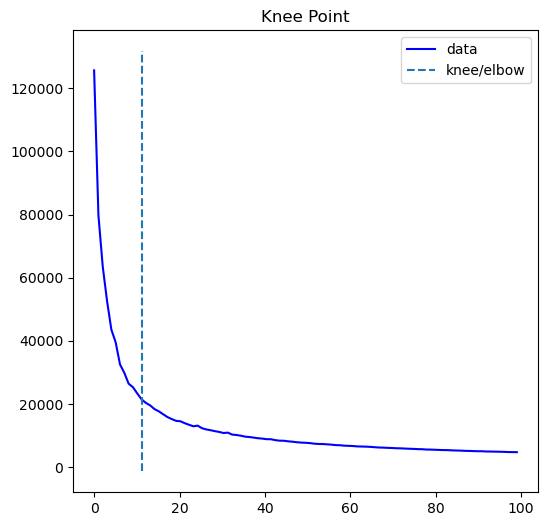

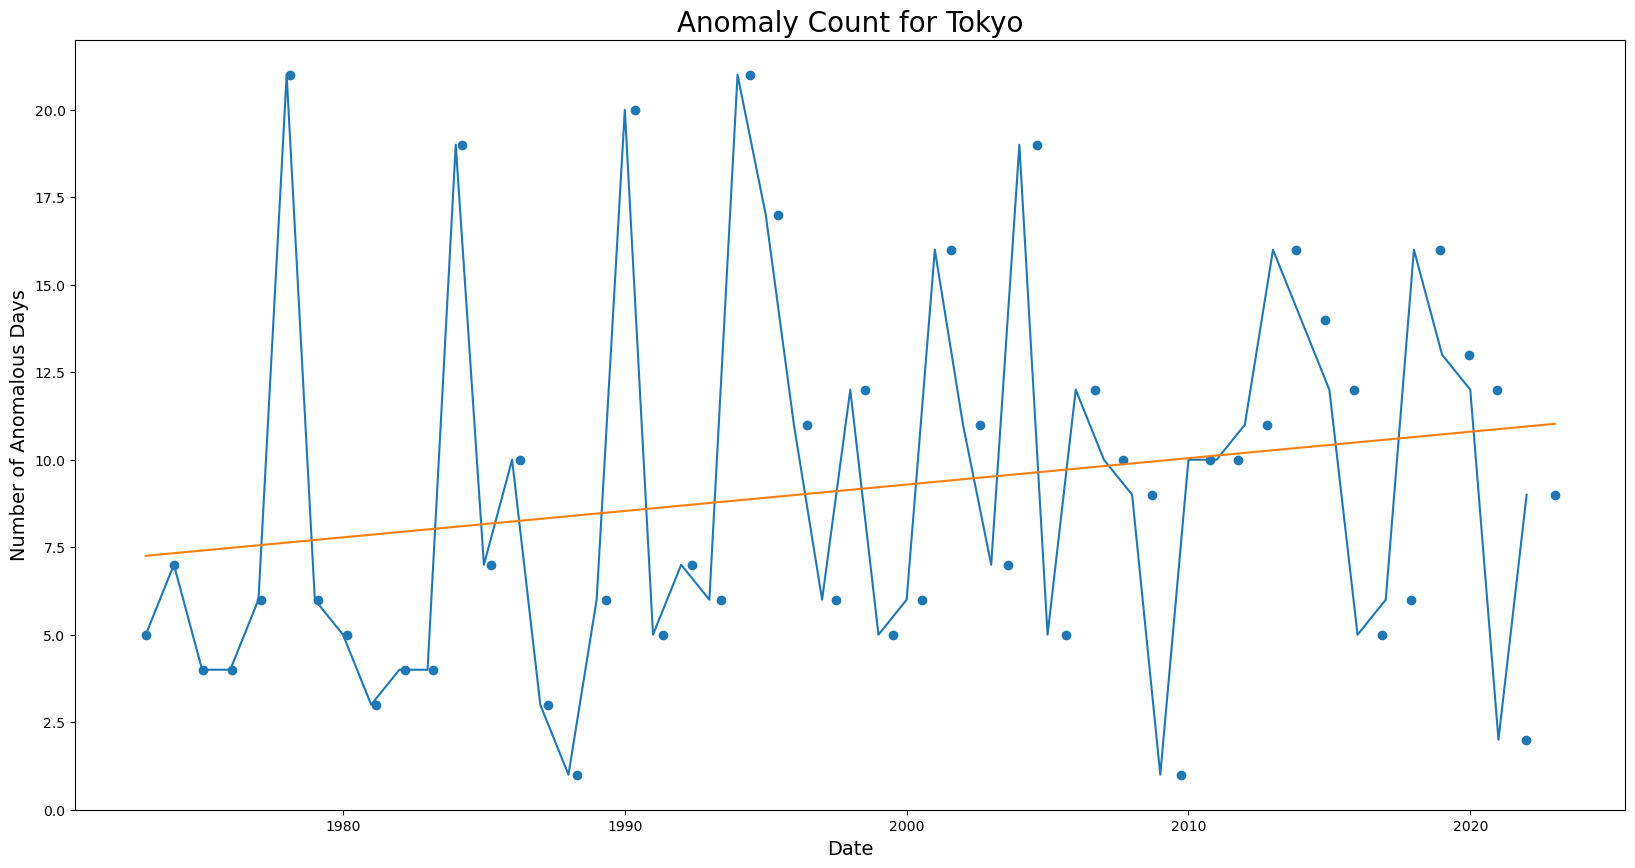

0.07543529411764682 -141.57971764705832 0.20727445180975831 0.1486490943779284 0.051389291090209795
Are missing values present?  [True]
There are  16  missing values present
Not a datetime index
Are there any duplicates?  False
Index duplicates?  False
For column weathercode the skew is 0.017848025660578148
For column temperature_2m_max the skew is 0.49117018852138605
For column temperature_2m_min the skew is -0.18155622566585713
For column temperature_2m_mean the skew is 0.03291517939899382
For column apparent_temperature_max the skew is 0.2925286608313183
For column apparent_temperature_min the skew is -0.027364779500601528
For column apparent_temperature_mean the skew is 0.05812973532744846
For column precipitation_sum the skew is 8.472133277021962
For column rain_sum the skew is 8.472133277021962
For column snowfall_sum the skew is 0
For column windspeed_10m_max the skew is 0.613665613498732
For column windgusts_10m_max the skew is 0.5126431639300124
-------------------------
For c

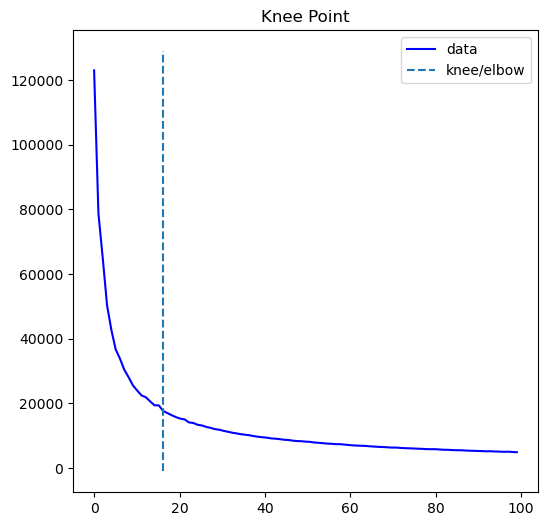

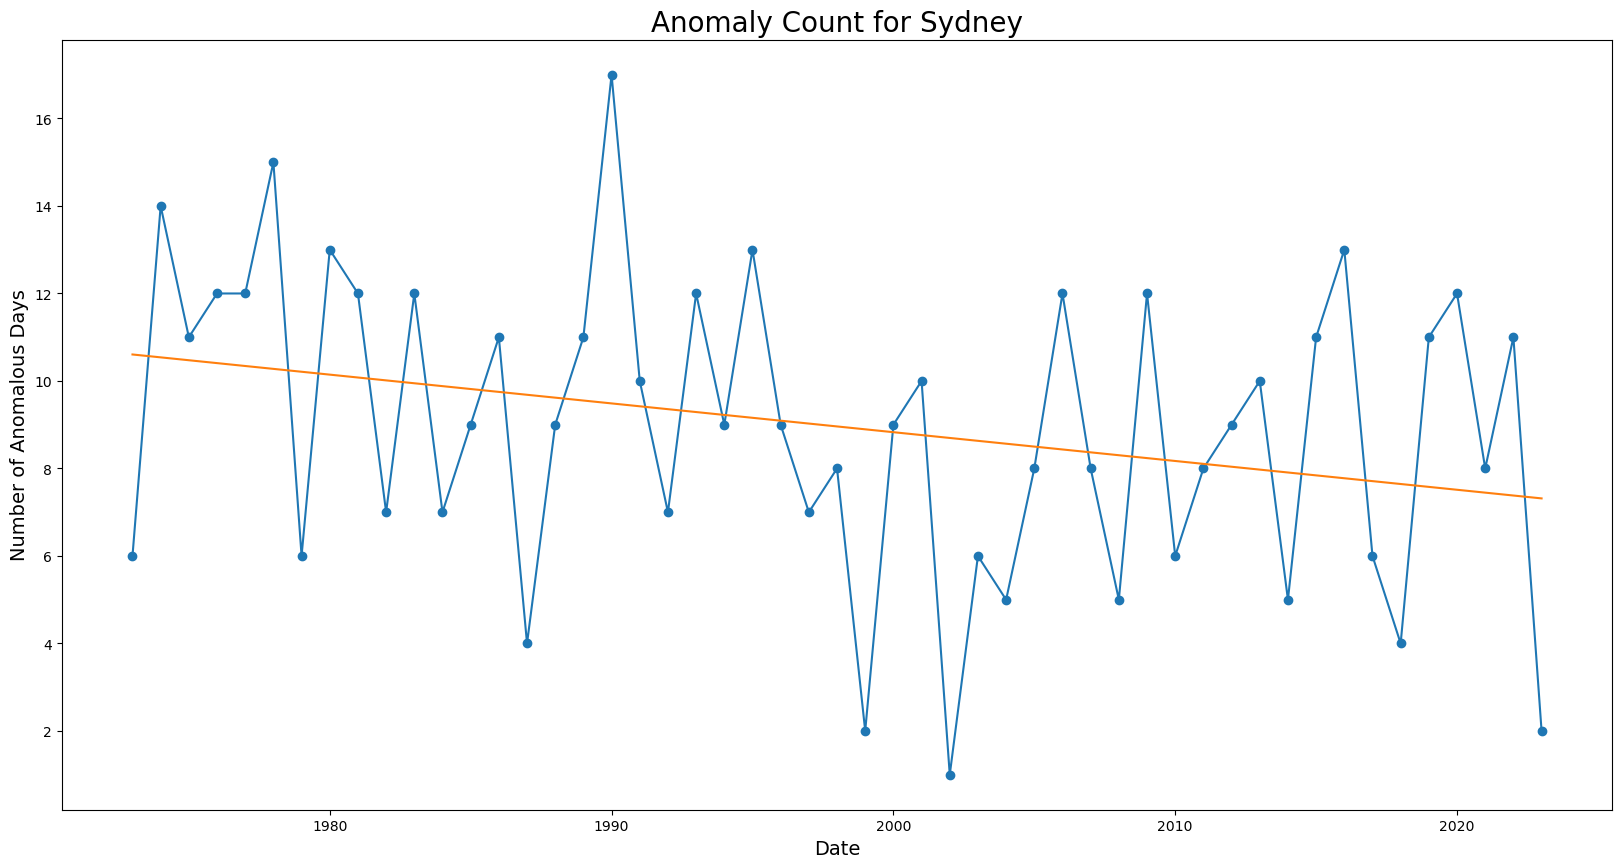

-0.06579185520361991 140.41291101055808 -0.2828337045333127 0.044322232043065346 0.03187410854645234
Are missing values present?  [True]
There are  16  missing values present
Not a datetime index
Are there any duplicates?  False
Index duplicates?  False
For column weathercode the skew is 0.8336834035336033
For column temperature_2m_max the skew is 0.3324723198671698
For column temperature_2m_min the skew is -0.199788979433292
For column temperature_2m_mean the skew is 0.21784739156424263
For column apparent_temperature_max the skew is 0.23345258384496873
For column apparent_temperature_min the skew is -0.006720257796416035
For column apparent_temperature_mean the skew is 0.22709405728713308
For column precipitation_sum the skew is 5.1097097933417235
For column rain_sum the skew is 5.1097097933417235
For column snowfall_sum the skew is 0
For column windspeed_10m_max the skew is 0.3927016540912775
For column windgusts_10m_max the skew is 0.33672666309819993
-------------------------
For 

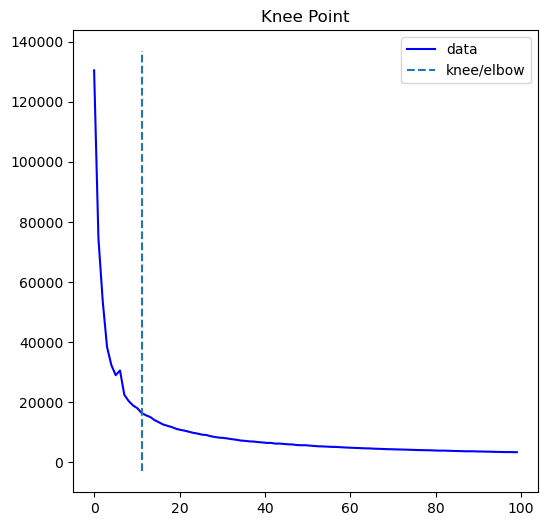

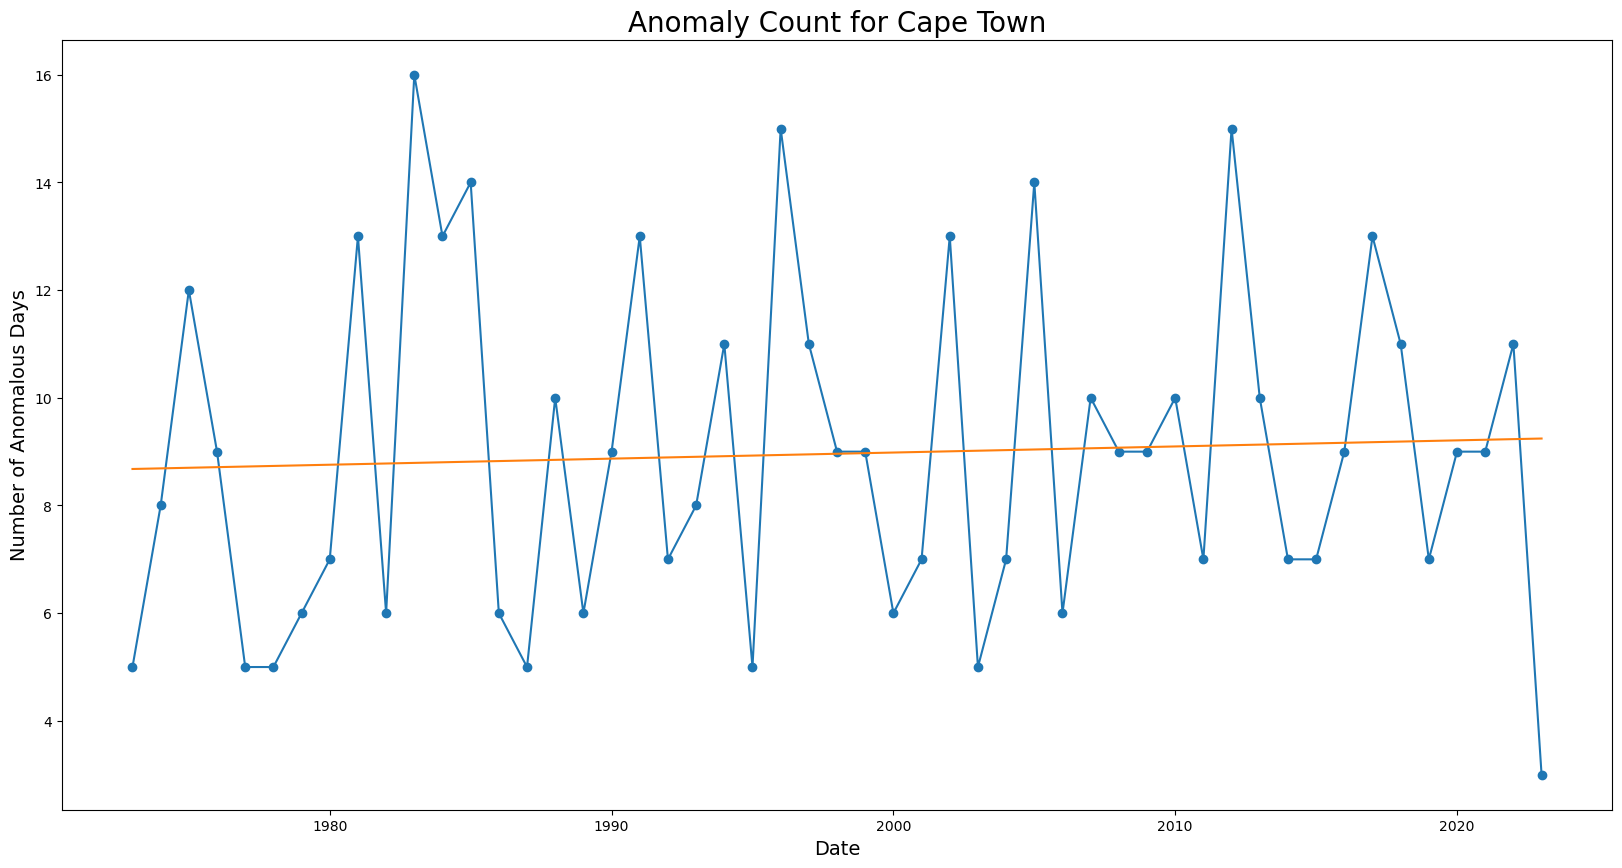

0.011312217194570123 -13.641025641025617 0.05318362515474943 0.710895483653251 0.030342872161233256
Are missing values present?  [True]
There are  16  missing values present
Not a datetime index
Are there any duplicates?  False
Index duplicates?  False
For column weathercode the skew is -0.30157163944965315
For column temperature_2m_max the skew is 0.10189557331300489
For column temperature_2m_min the skew is -0.2951974227555679
For column temperature_2m_mean the skew is 0.10196192958507239
For column apparent_temperature_max the skew is 0.04032449032400999
For column apparent_temperature_min the skew is -0.17447174110510721
For column apparent_temperature_mean the skew is 0.028176338592956335
For column precipitation_sum the skew is 6.489547471245604
For column rain_sum the skew is 6.489547471245604
For column snowfall_sum the skew is 0
For column windspeed_10m_max the skew is 0.914656117926115
For column windgusts_10m_max the skew is 1.0213601055380666
-------------------------
For c

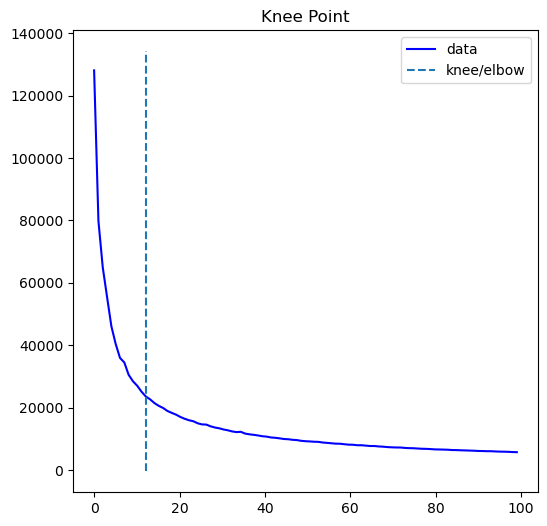

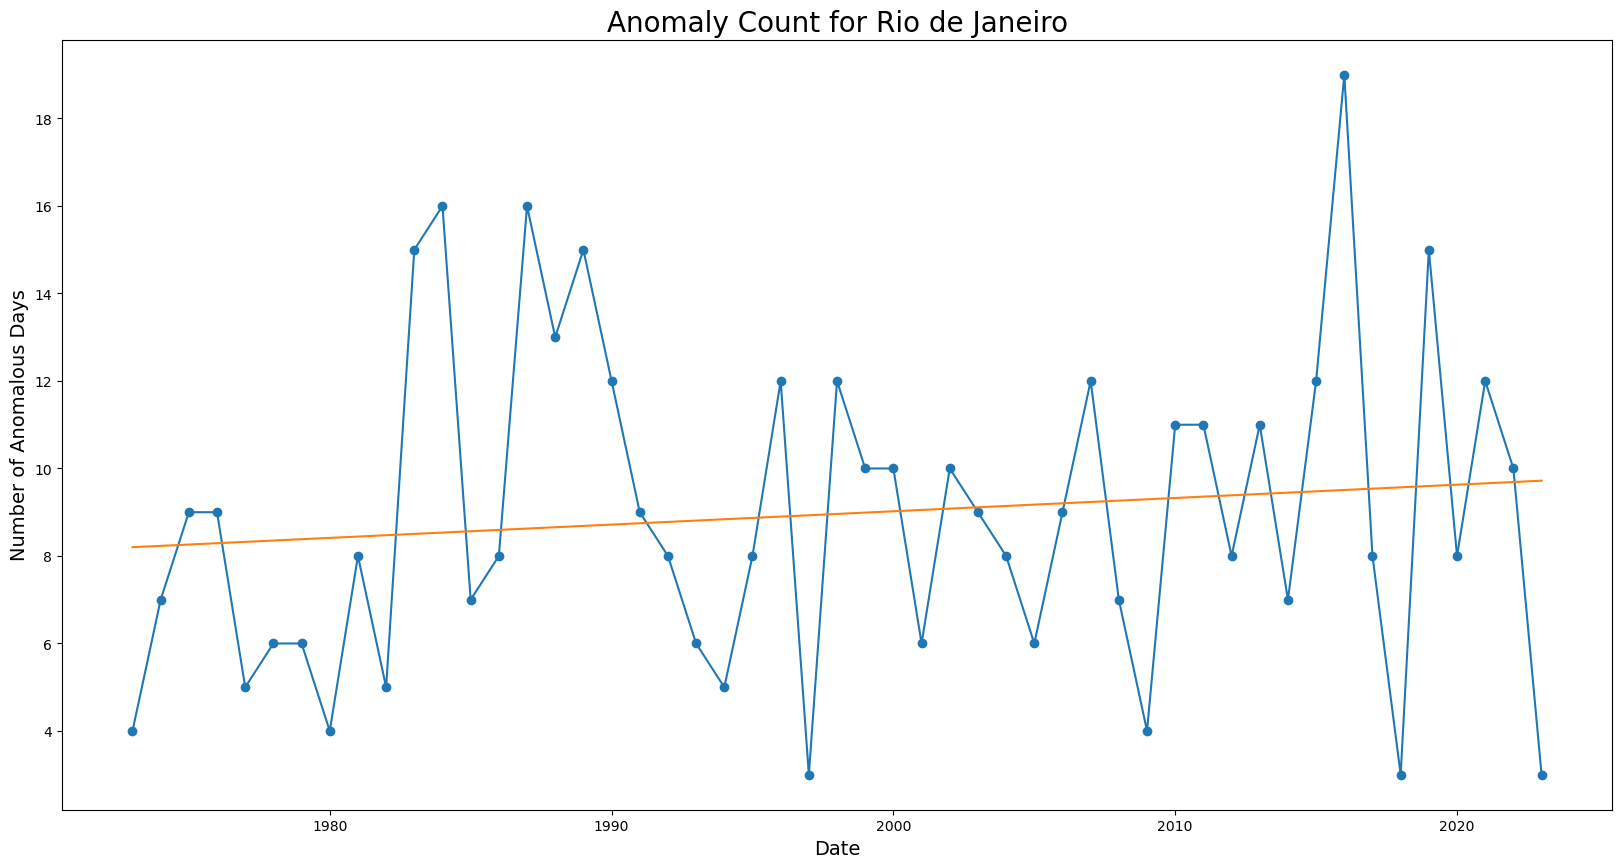

0.030407239819004516 -51.79288084464553 0.12151494762602585 0.39564160240372725 0.03548288932106045
Are missing values present?  [True]
There are  16  missing values present
Not a datetime index
Are there any duplicates?  False
Index duplicates?  False
For column weathercode the skew is -0.23380358697089867
For column temperature_2m_max the skew is -0.21554830316131546
For column temperature_2m_min the skew is -0.5179276105328456
For column temperature_2m_mean the skew is -0.35248125356706733
For column apparent_temperature_max the skew is -0.08268353567225475
For column apparent_temperature_min the skew is -0.3191085048088561
For column apparent_temperature_mean the skew is -0.18538606092830273
For column precipitation_sum the skew is 3.953888074408987
For column rain_sum the skew is 4.731758110168413
For column snowfall_sum the skew is 5.038655660456995
For column windspeed_10m_max the skew is 0.5153800316446605
For column windgusts_10m_max the skew is 0.5102974821021472
------------

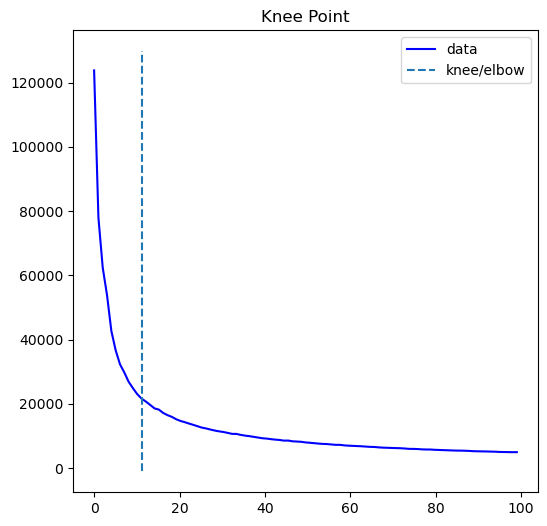

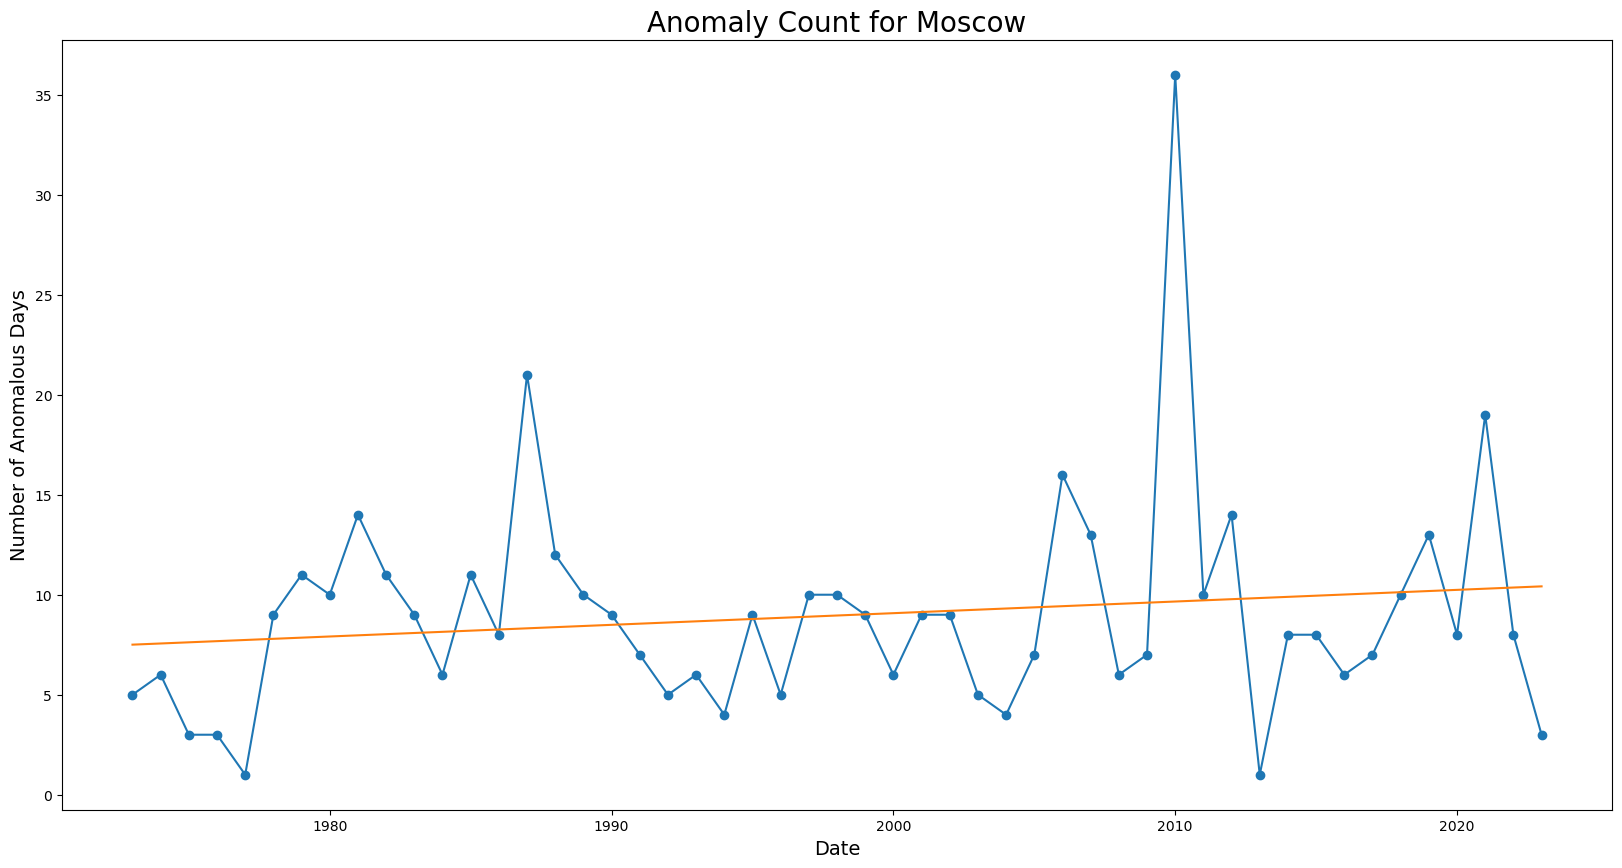

0.05828054298642534 -107.48374057315235 0.1553140976258748 0.276468238016945 0.052955653392566304
Are missing values present?  [True]
There are  16  missing values present
Not a datetime index
Are there any duplicates?  False
Index duplicates?  False
For column weathercode the skew is 0.0337306606468472
For column temperature_2m_max the skew is -0.15139228693910517
For column temperature_2m_min the skew is -0.3114665407326778
For column temperature_2m_mean the skew is -0.23487428582220699
For column apparent_temperature_max the skew is -0.04279264369486245
For column apparent_temperature_min the skew is -0.1279375469632176
For column apparent_temperature_mean the skew is -0.08482708628630689
For column precipitation_sum the skew is 3.758533753188742
For column rain_sum the skew is 4.201401279519052
For column snowfall_sum the skew is 8.060570599937181
For column windspeed_10m_max the skew is 0.6479145046883349
For column windgusts_10m_max the skew is 0.7947652018388165
----------------

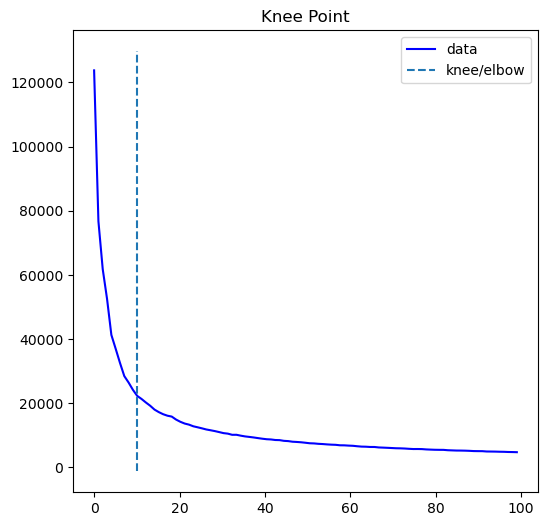

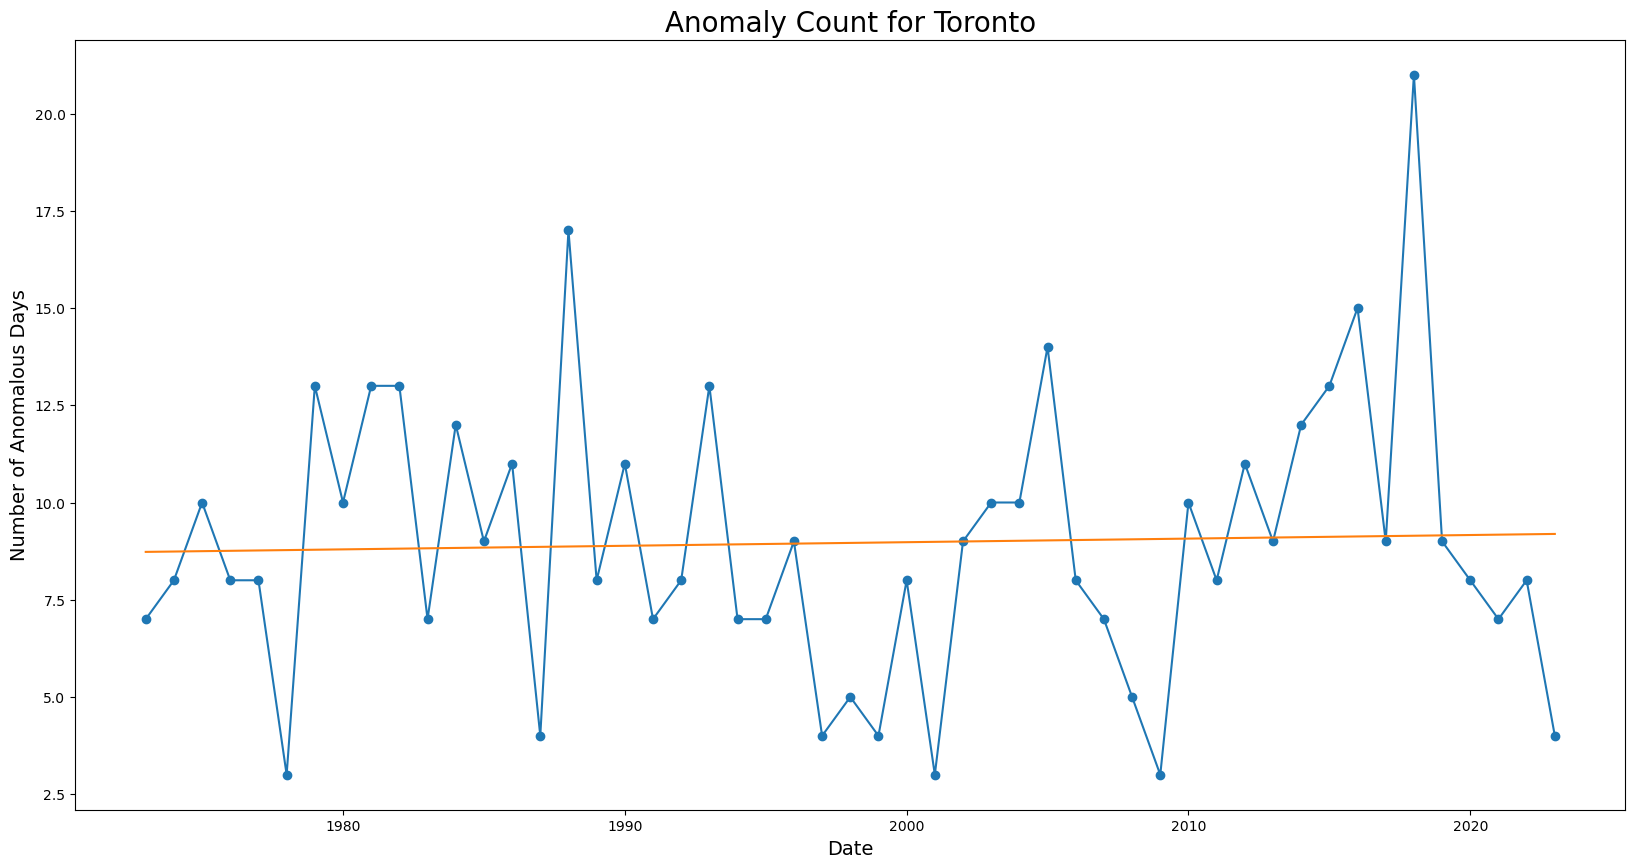

0.009230769230769232 -9.482292609351436 0.03771514366521679 0.7927384991106289 0.03493936359713946
Are missing values present?  [True]
There are  16  missing values present
Not a datetime index
Are there any duplicates?  False
Index duplicates?  False
For column weathercode the skew is -0.6476998547361354
For column temperature_2m_max the skew is -0.4506466617535143
For column temperature_2m_min the skew is -0.7089932577989368
For column temperature_2m_mean the skew is -0.6063582356753093
For column apparent_temperature_max the skew is -0.2669641886487235
For column apparent_temperature_min the skew is -0.4441569370967343
For column apparent_temperature_mean the skew is -0.36714890150206625
For column precipitation_sum the skew is 2.215177210574176
For column rain_sum the skew is 2.4368126555554803
For column snowfall_sum the skew is 5.173882900620852
For column windspeed_10m_max the skew is 0.6636944112416375
For column windgusts_10m_max the skew is 0.8085904906301513
----------------

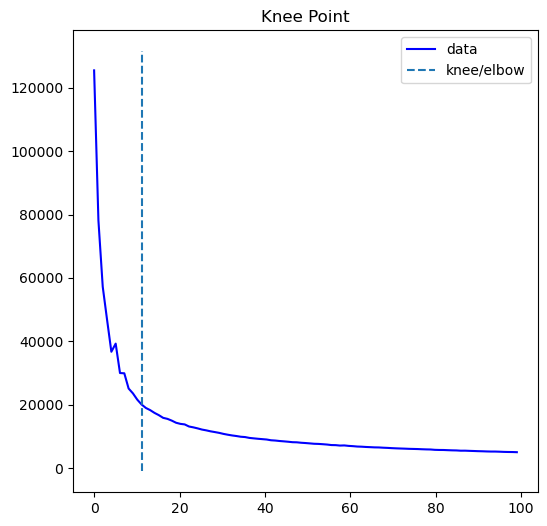

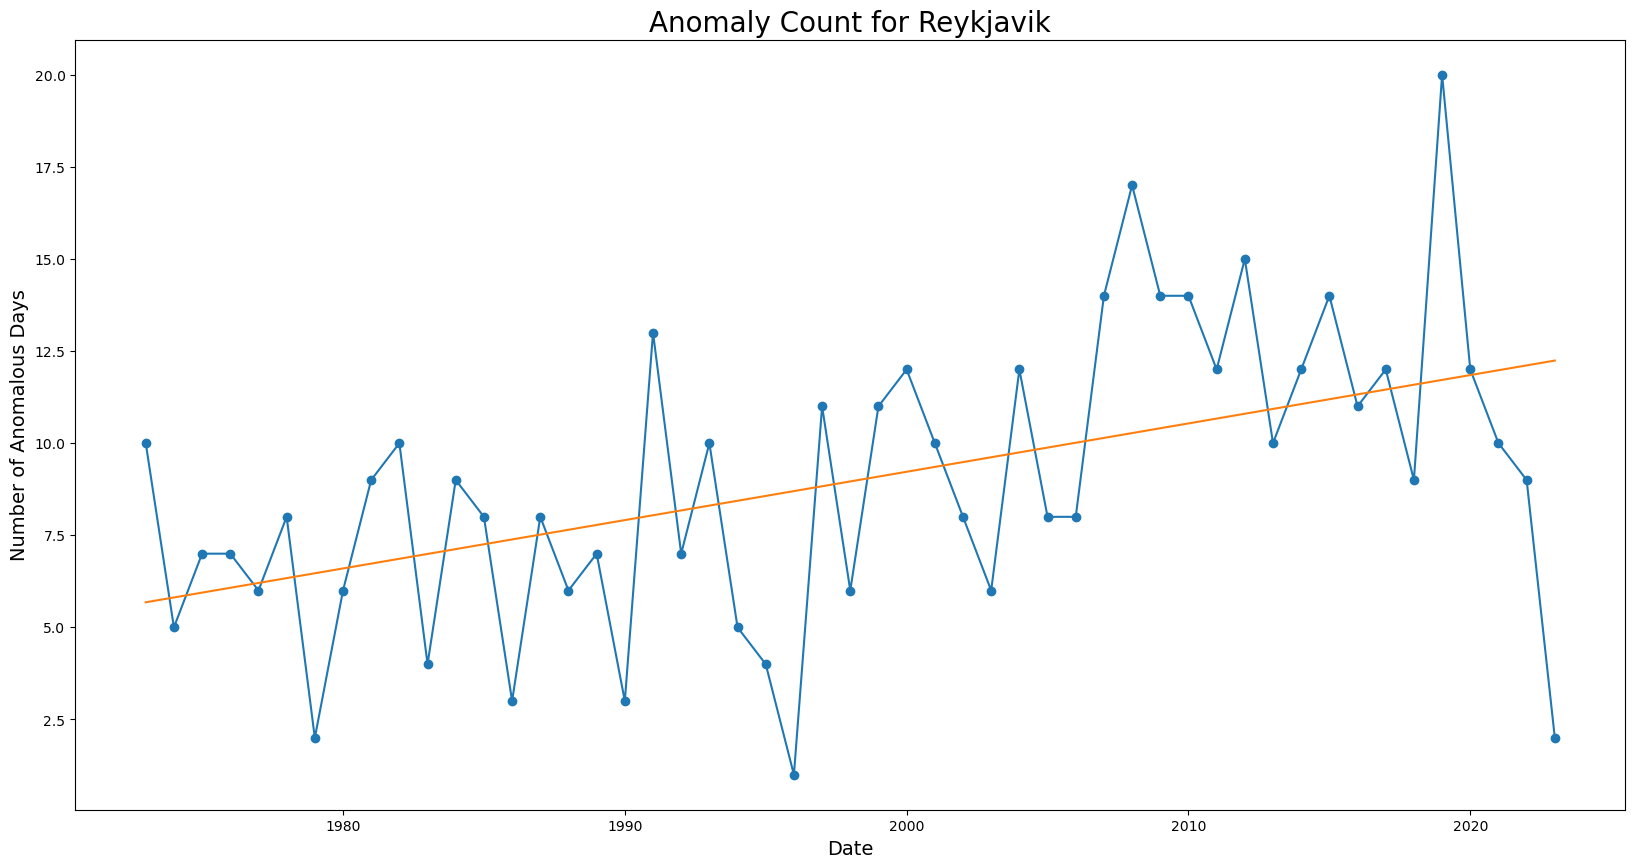

0.13122171945701358 -253.22021116138765 0.4901689277606811 0.00026105584983101014 0.0333344127591195


In [19]:
for city in location_names:
    data_worker = DataWorker(weather_df,city)
    data_worker.na_check().datetime_index_na_check().check_duplicates().get_float_cols().check_uniform()
    data_worker.data.drop(['rain_sum','snowfall_sum','temperature_2m_mean','apparent_temperature_mean','apparent_temperature_max','apparent_temperature_min','temperature_2m_min','windspeed_10m_max'],axis=1,inplace=True)
    data_worker.float_columns=[col for col in data_worker.float_columns if col not in ['rain_sum','snowfall_sum','temperature_2m_mean','apparent_temperature_mean','apparent_temperature_max','apparent_temperature_min','temperature_2m_min','windspeed_10m_max']]
    print('-'*10)
    data_worker.check_uniform(False).train_test().normalize().compute_vif()
    
    distortions = []
    K = range(1,100)
    for k in K:
        kmeanModel = KMeans(n_clusters=k,n_init='auto')
        kmeanModel.fit(data_worker.X_total)
        distortions.append(kmeanModel.inertia_)
    data_worker.X_train_orig = pd.DataFrame(data_worker.X_train_orig)
    x = np.array(np.linspace(0,len(distortions),len(distortions)))
    y = distortions
    kneedle = KneeLocator(x, y, S=3.0, curve="convex", direction="decreasing",online=True)
    kneedle.plot_knee()
    n_neighbors=int(kneedle.knee)
    
    
    model=LocalOutlierFactor(n_neighbors=n_neighbors,n_jobs=-1,novelty=True,algorithm='brute')
    model.fit(data_worker.X_train)
    scores = model.decision_function(data_worker.X_test)
    thresh = quantile(scores, .025)
    index = where(scores <= thresh)
    outliers = data_worker.X_test_orig.iloc[index]
    outliers=pd.DataFrame(outliers)
    outliers.to_csv(f'LocalOutlierFactor_outliers_{city}.csv')

    
    data_worker.X_test_orig['time']=pd.to_datetime(data_worker.X_test_orig.loc[:,'time'],format='%Y-%m-%d')
    outliers = data_worker.X_test_orig.iloc[index].groupby(data_worker.X_test_orig['time'].dt.year).count()
    plt.figure(figsize=(20,10))
    plt.plot(outliers.iloc[:,-1])
    a, b = np.polyfit(np.array(np.linspace(min(data_worker.X_test_orig['time'].dt.year),max(data_worker.X_test_orig['time'].dt.year),num=len(outliers))), outliers.iloc[:,-1], 1)
    x=np.array(np.linspace(min(data_worker.X_test_orig['time'].dt.year),max(data_worker.X_test_orig['time'].dt.year),num=len(outliers)))
    y=outliers.iloc[:,-1]
    plt.scatter(x, y)

    #add line of best fit to plot
    plt.plot(x, a*x+b)   
    plt.title(f'Anomaly Count for {city}',fontsize=20)
    plt.xlabel('Date',fontsize=14)
    plt.ylabel('Number of Anomalous Days',fontsize=14)
    plt.show()
    slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(x, y)
    print(slope,intercept,r_value,p_value,std_err)

# Isolation Forest

The Isolation Forest algorithm is a tree-based method for anomaly detection. As mentioned earlier, we don't need to be overly concerned about extensive data preparation since it is a tree-based approach.

To determine the optimal hyperparameters for the Isolation Forest model, we experimented with a range of values to achieve the best correlation (R value) between the count of anomalies and the corresponding years. Typically, a hyperparameter search would involve using a validation set. However, in our case, without a separate validation set, we manually explored different parameter values, which proved to be a relatively quick process.

Are missing values present?  [True]
There are  16  missing values present
Not a datetime index
Are there any duplicates?  False
Index duplicates?  False
----------
For column weathercode the skew is -0.1265399448592719
For column temperature_2m_max the skew is -0.06178609123037139
For column temperature_2m_min the skew is -0.08725141152044845
For column temperature_2m_mean the skew is -0.08095571840544646
For column apparent_temperature_max the skew is 0.05748580021773185
For column apparent_temperature_min the skew is 0.0646916866430364
For column apparent_temperature_mean the skew is 0.04878594469898302
For column precipitation_sum the skew is 5.585894462508631
For column rain_sum the skew is 5.6670127910069334
For column snowfall_sum the skew is 26.886275263755895
For column windspeed_10m_max the skew is 1.4004094949733379
For column windgusts_10m_max the skew is 1.5334073330122118
-------------------------
Features used:  Index(['time', 'location_name', 'weathercode', 'temperature_

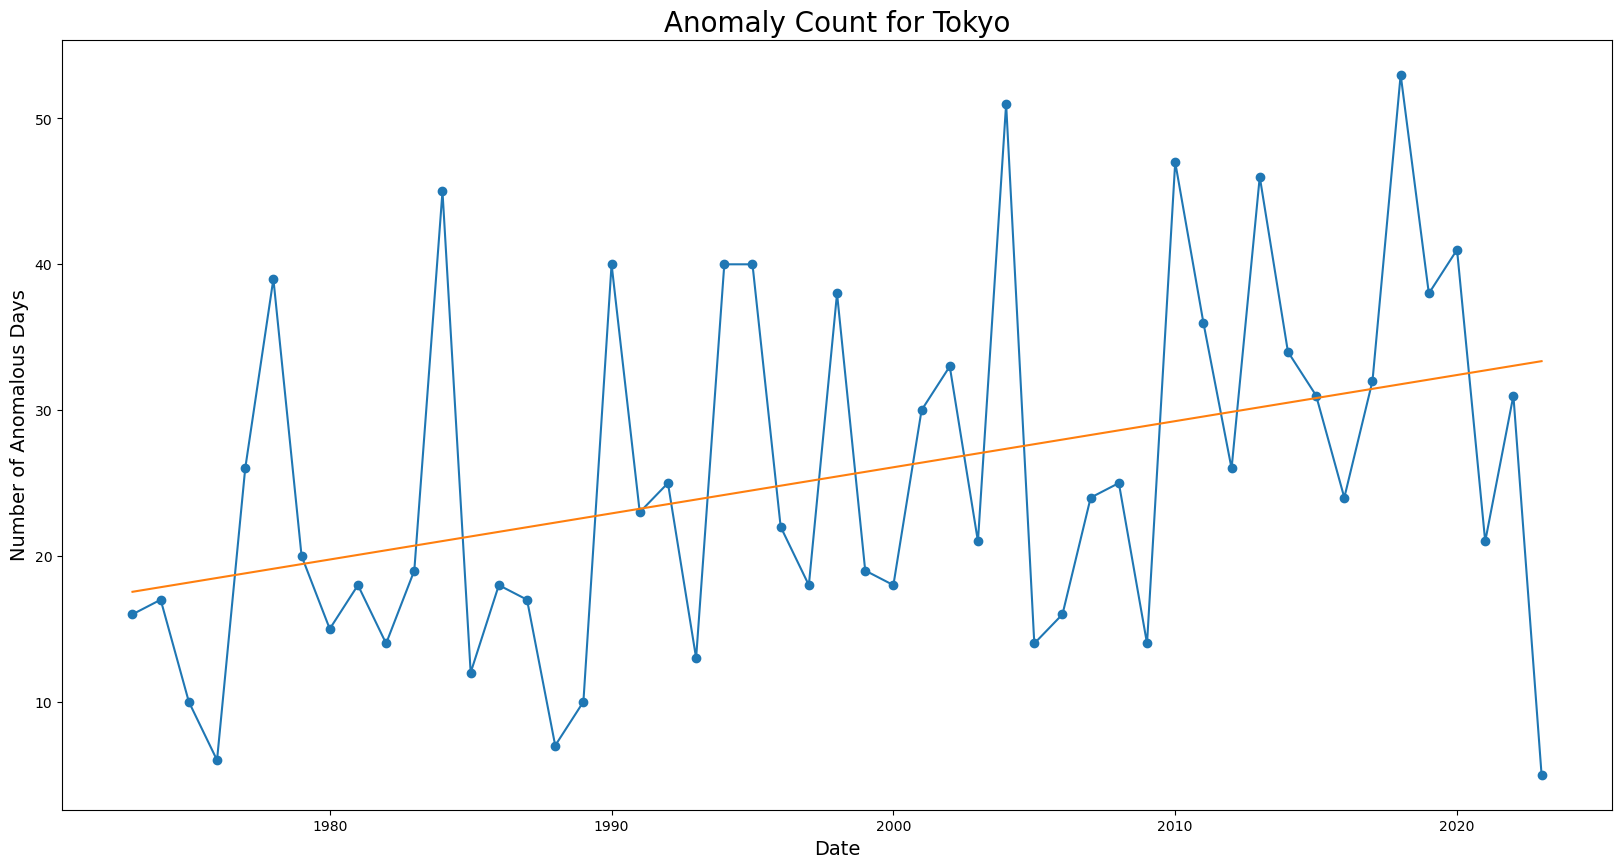

0.31628959276018104 -606.4956259426848 0.3815160418318506 0.005738591438832002 0.10947532527975284
Are missing values present?  [True]
There are  16  missing values present
Not a datetime index
Are there any duplicates?  False
Index duplicates?  False
----------
For column weathercode the skew is 0.017848025660578148
For column temperature_2m_max the skew is 0.49117018852138605
For column temperature_2m_min the skew is -0.18155622566585713
For column temperature_2m_mean the skew is 0.03291517939899382
For column apparent_temperature_max the skew is 0.2925286608313183
For column apparent_temperature_min the skew is -0.027364779500601528
For column apparent_temperature_mean the skew is 0.05812973532744846
For column precipitation_sum the skew is 8.472133277021962
For column rain_sum the skew is 8.472133277021962
For column snowfall_sum the skew is 0
For column windspeed_10m_max the skew is 0.613665613498732
For column windgusts_10m_max the skew is 0.5126431639300124
---------------------

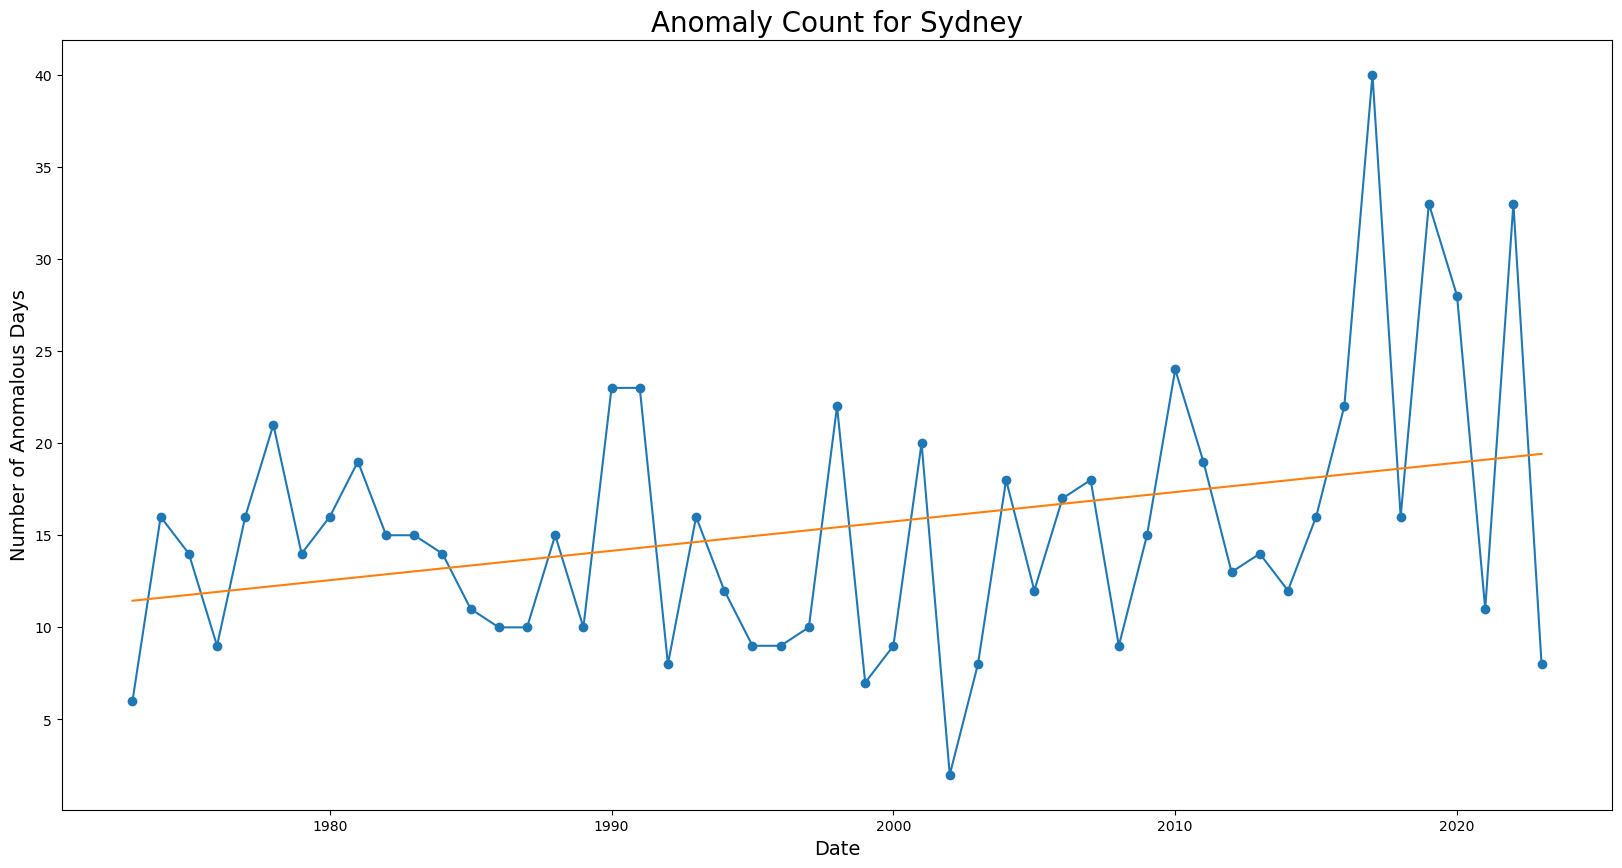

0.15945701357466063 -303.1637405731523 0.32448181585569197 0.02017582938919768 0.06640438280412701
Are missing values present?  [True]
There are  16  missing values present
Not a datetime index
Are there any duplicates?  False
Index duplicates?  False
----------
For column weathercode the skew is 0.8336834035336033
For column temperature_2m_max the skew is 0.3324723198671698
For column temperature_2m_min the skew is -0.199788979433292
For column temperature_2m_mean the skew is 0.21784739156424263
For column apparent_temperature_max the skew is 0.23345258384496873
For column apparent_temperature_min the skew is -0.006720257796416035
For column apparent_temperature_mean the skew is 0.22709405728713308
For column precipitation_sum the skew is 5.1097097933417235
For column rain_sum the skew is 5.1097097933417235
For column snowfall_sum the skew is 0
For column windspeed_10m_max the skew is 0.3927016540912775
For column windgusts_10m_max the skew is 0.33672666309819993
---------------------

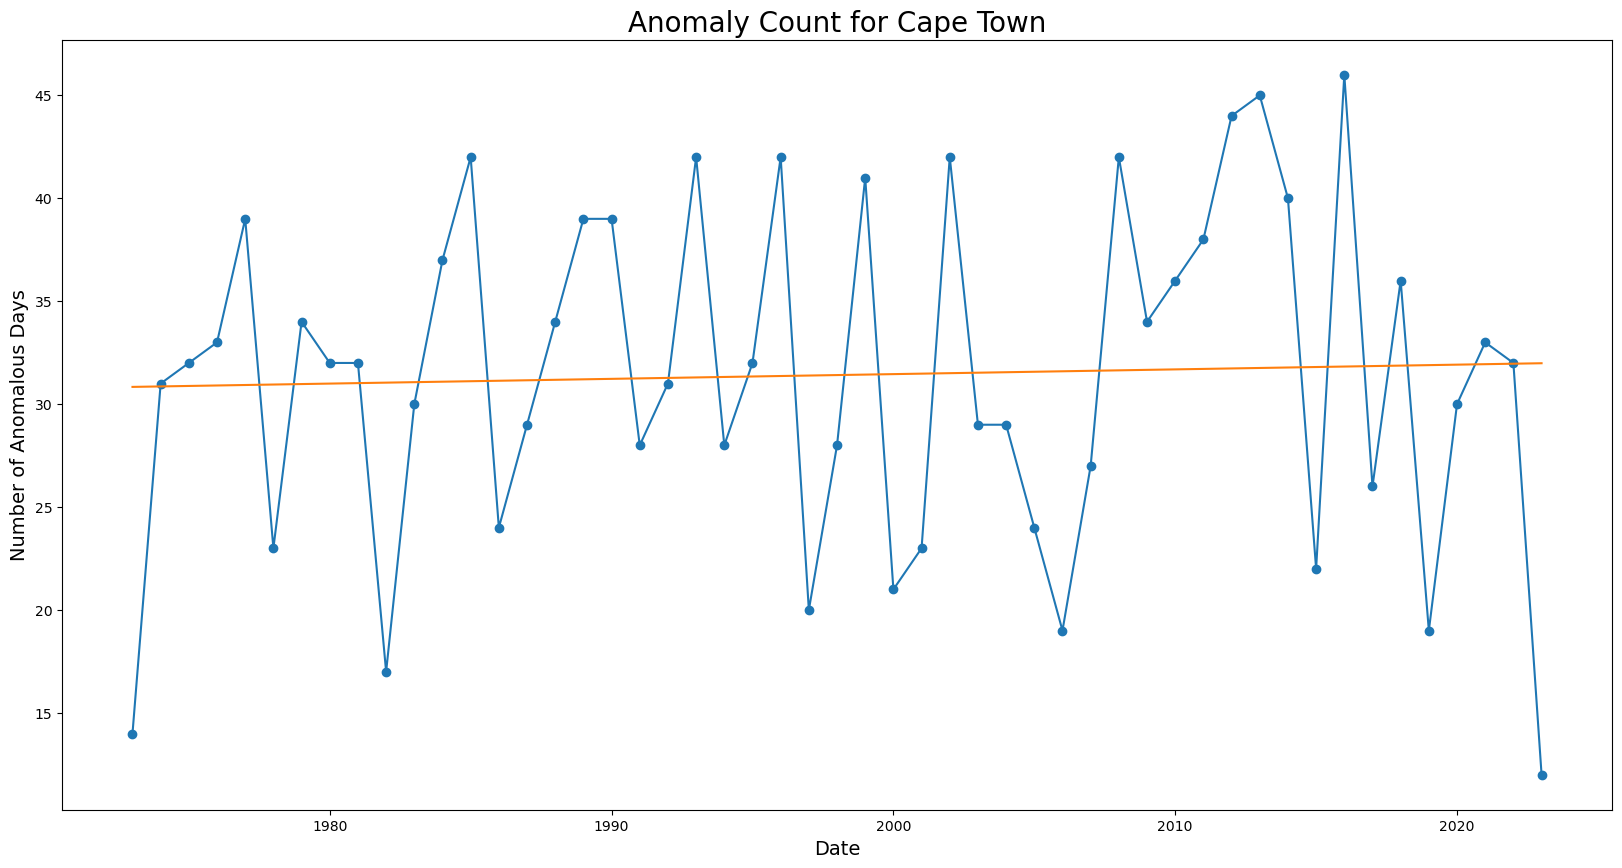

0.022986425339366536 -14.515113122171986 0.04096998021094428 0.7752990037005414 0.08008346358513599
Are missing values present?  [True]
There are  16  missing values present
Not a datetime index
Are there any duplicates?  False
Index duplicates?  False
----------
For column weathercode the skew is -0.30157163944965315
For column temperature_2m_max the skew is 0.10189557331300489
For column temperature_2m_min the skew is -0.2951974227555679
For column temperature_2m_mean the skew is 0.10196192958507239
For column apparent_temperature_max the skew is 0.04032449032400999
For column apparent_temperature_min the skew is -0.17447174110510721
For column apparent_temperature_mean the skew is 0.028176338592956335
For column precipitation_sum the skew is 6.489547471245604
For column rain_sum the skew is 6.489547471245604
For column snowfall_sum the skew is 0
For column windspeed_10m_max the skew is 0.914656117926115
For column windgusts_10m_max the skew is 1.0213601055380666
--------------------

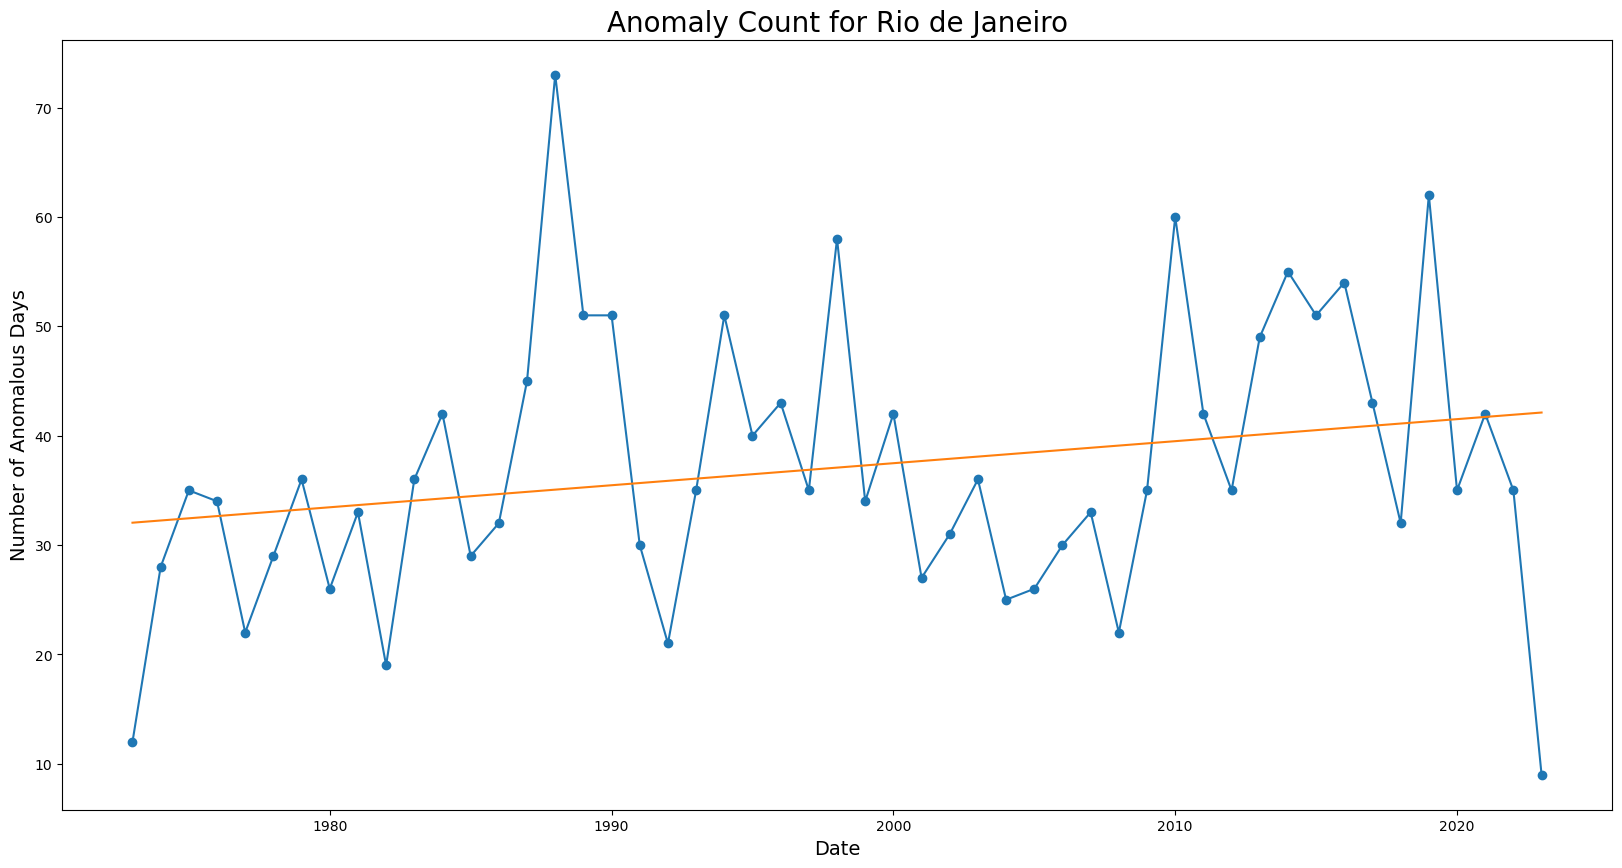

0.20144796380090502 -365.4146003016592 0.23564286885757074 0.0959844593407806 0.11868755543487157
Are missing values present?  [True]
There are  16  missing values present
Not a datetime index
Are there any duplicates?  False
Index duplicates?  False
----------
For column weathercode the skew is -0.23380358697089867
For column temperature_2m_max the skew is -0.21554830316131546
For column temperature_2m_min the skew is -0.5179276105328456
For column temperature_2m_mean the skew is -0.35248125356706733
For column apparent_temperature_max the skew is -0.08268353567225475
For column apparent_temperature_min the skew is -0.3191085048088561
For column apparent_temperature_mean the skew is -0.18538606092830273
For column precipitation_sum the skew is 3.953888074408987
For column rain_sum the skew is 4.731758110168413
For column snowfall_sum the skew is 5.038655660456995
For column windspeed_10m_max the skew is 0.5153800316446605
For column windgusts_10m_max the skew is 0.5102974821021472
---

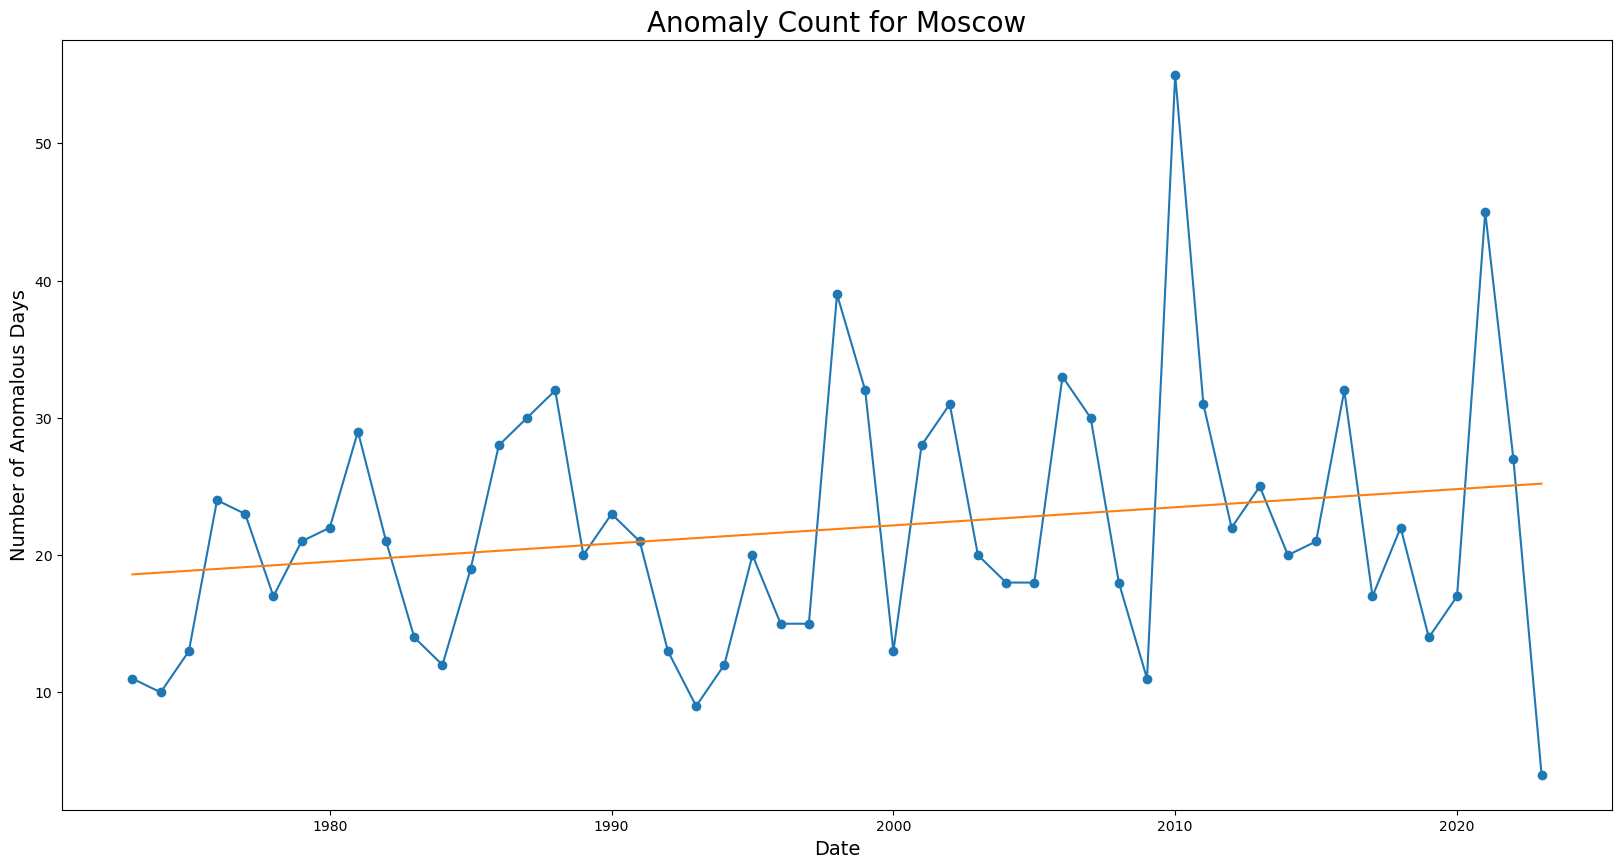

0.13221719457013575 -242.2679939668175 0.20768365213342155 0.14363511299502024 0.08896383332336465
Are missing values present?  [True]
There are  16  missing values present
Not a datetime index
Are there any duplicates?  False
Index duplicates?  False
----------
For column weathercode the skew is 0.0337306606468472
For column temperature_2m_max the skew is -0.15139228693910517
For column temperature_2m_min the skew is -0.3114665407326778
For column temperature_2m_mean the skew is -0.23487428582220699
For column apparent_temperature_max the skew is -0.04279264369486245
For column apparent_temperature_min the skew is -0.1279375469632176
For column apparent_temperature_mean the skew is -0.08482708628630689
For column precipitation_sum the skew is 3.758533753188742
For column rain_sum the skew is 4.201401279519052
For column snowfall_sum the skew is 8.060570599937181
For column windspeed_10m_max the skew is 0.6479145046883349
For column windgusts_10m_max the skew is 0.7947652018388165
----

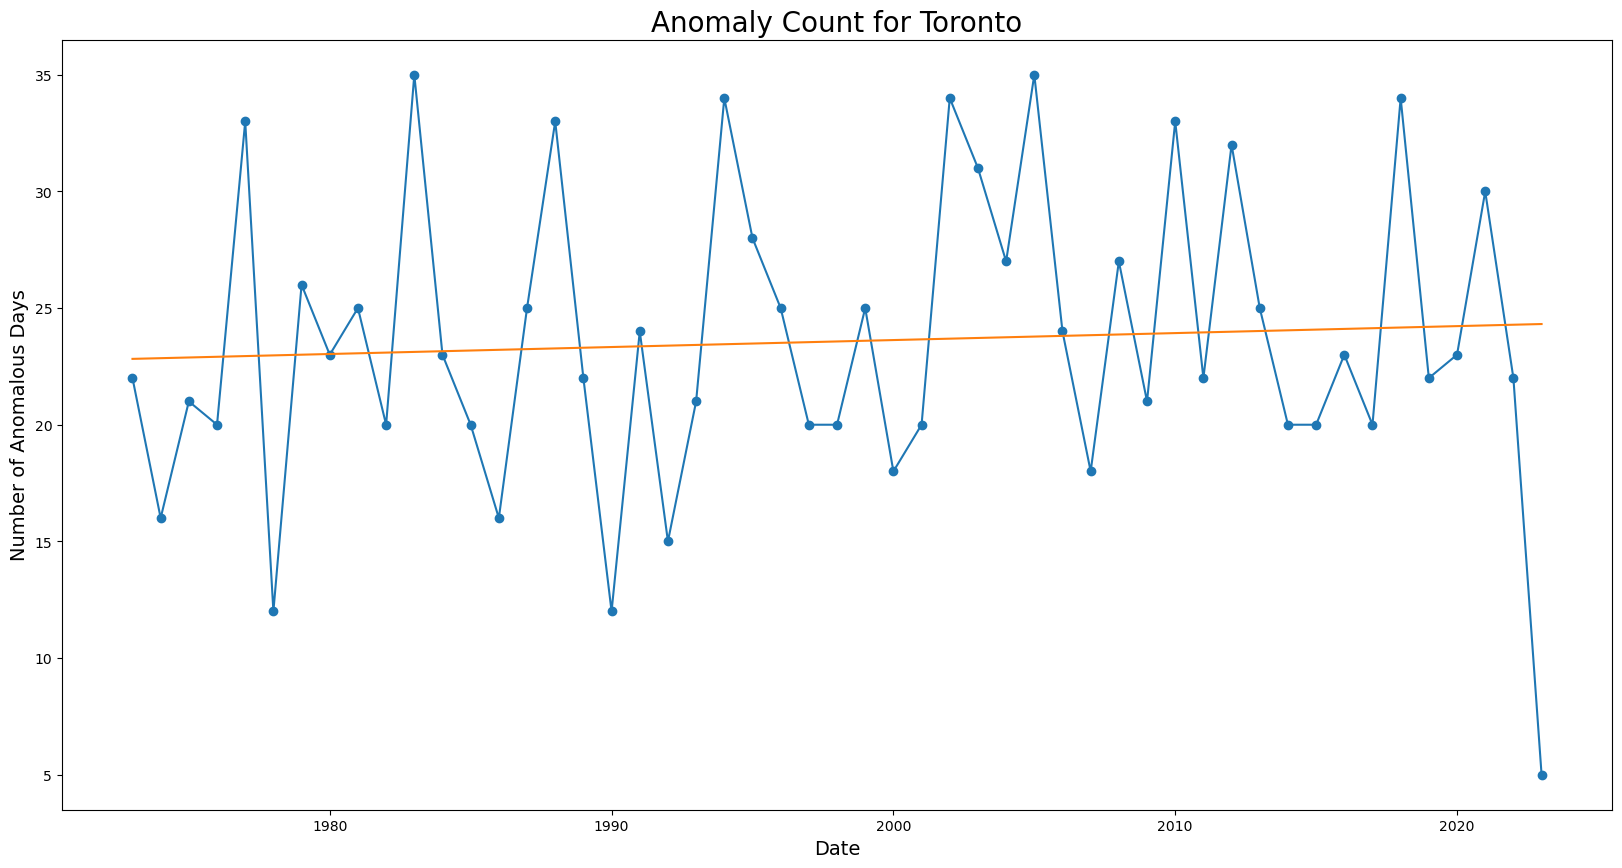

0.02986425339366518 -36.10015082956264 0.06862763774384563 0.6322843739409638 0.06201966926957472
Are missing values present?  [True]
There are  16  missing values present
Not a datetime index
Are there any duplicates?  False
Index duplicates?  False
----------
For column weathercode the skew is -0.6476998547361354
For column temperature_2m_max the skew is -0.4506466617535143
For column temperature_2m_min the skew is -0.7089932577989368
For column temperature_2m_mean the skew is -0.6063582356753093
For column apparent_temperature_max the skew is -0.2669641886487235
For column apparent_temperature_min the skew is -0.4441569370967343
For column apparent_temperature_mean the skew is -0.36714890150206625
For column precipitation_sum the skew is 2.215177210574176
For column rain_sum the skew is 2.4368126555554803
For column snowfall_sum the skew is 5.173882900620852
For column windspeed_10m_max the skew is 0.6636944112416375
For column windgusts_10m_max the skew is 0.8085904906301513
------

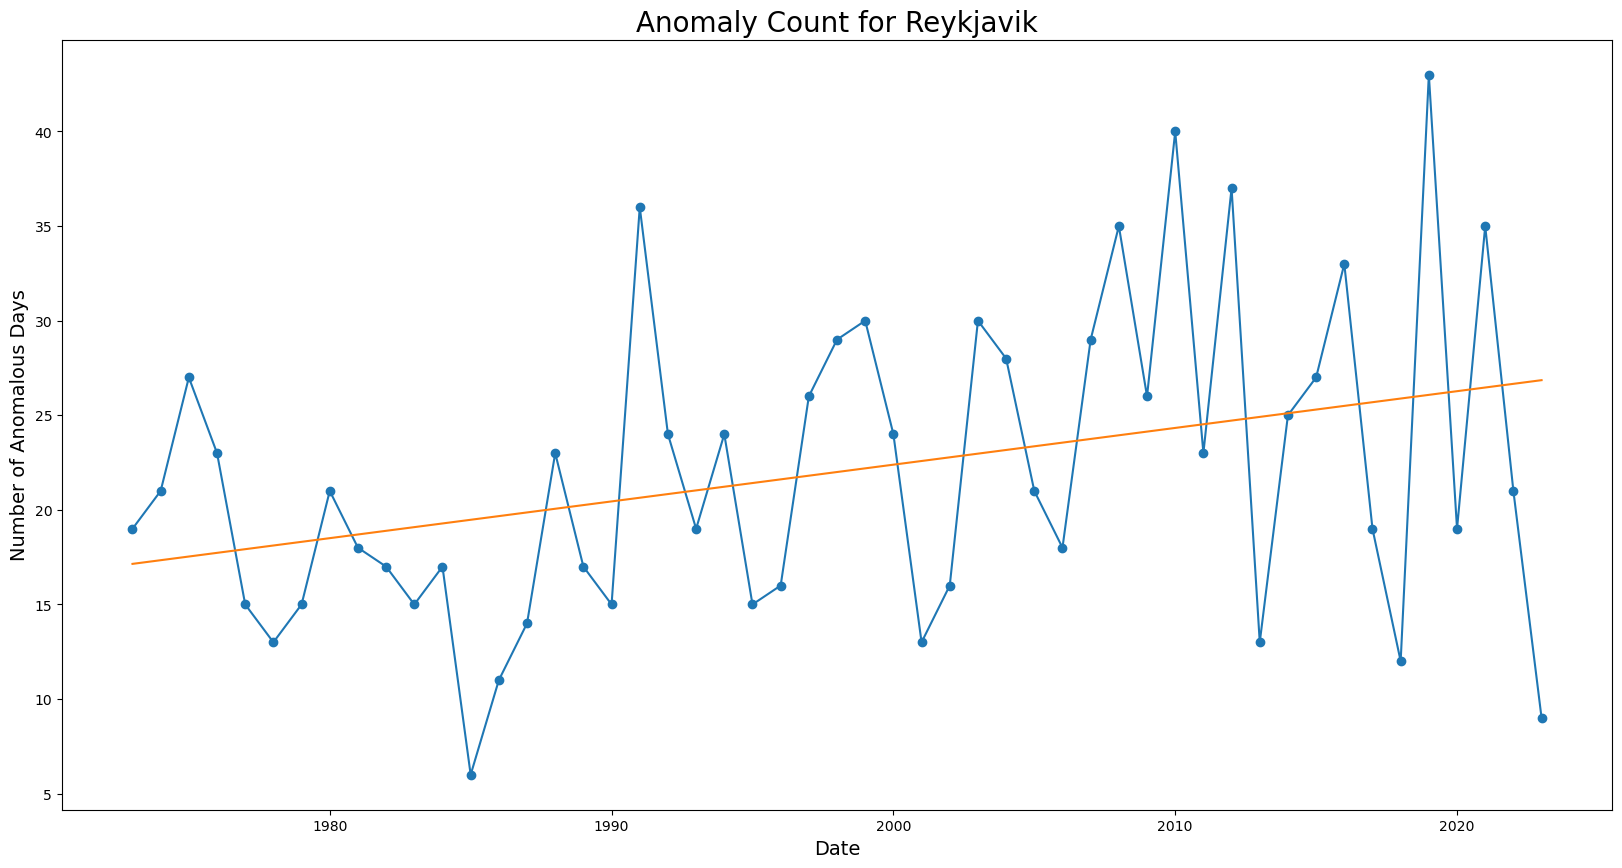

0.1942081447963801 -366.02787330316744 0.3485792399313074 0.01218255454964085 0.07459967121360943


In [20]:
for city in location_names:
    data_worker = DataWorker(weather_df,city)
    data_worker.na_check().datetime_index_na_check().check_duplicates().get_float_cols()
    print('-'*10)
    data_worker.check_uniform(False).train_test().normalize(False,False).compute_vif()
    model=IsolationForest(n_estimators=25,max_samples=1.0,max_features=3,random_state=0)
    model.fit(data_worker.X_train)
    scores = model.predict(data_worker.X_test)
    index = where(scores == -1)
    outliers = data_worker.X_test_orig.iloc[index]
    outliers=pd.DataFrame(outliers)
    outliers.to_csv(f'IsolationForest_outliers_{city}.csv')

    
    data_worker.X_test_orig['time']=pd.to_datetime(data_worker.X_test_orig.loc[:,'time'],format='%Y-%m-%d')
    outliers = data_worker.X_test_orig.iloc[index].groupby(data_worker.X_test_orig['time'].dt.year).count()
    plt.figure(figsize=(20,10))
    plt.plot(outliers.iloc[:,-1])
    a, b = np.polyfit(np.array(np.linspace(min(data_worker.X_test_orig['time'].dt.year),max(data_worker.X_test_orig['time'].dt.year),num=len(outliers))), outliers.iloc[:,-1], 1)
    x=np.array(np.linspace(min(data_worker.X_test_orig['time'].dt.year),max(data_worker.X_test_orig['time'].dt.year),num=len(outliers)))
    y=outliers.iloc[:,-1]
    plt.scatter(x, y)

    #add line of best fit to plot
    plt.plot(x, a*x+b)   
    plt.title(f'Anomaly Count for {city}',fontsize=20)
    plt.xlabel('Date',fontsize=14)
    plt.ylabel('Number of Anomalous Days',fontsize=14)
    plt.show()
    slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(x, y)
    print(slope,intercept,r_value,p_value,std_err)